In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import shapely
import geopandas as gpd
import seaborn as sns



# Tricity public bus delay analysis prediction

## Data collection
### Source of data

Open data of estimated departure times source(https://ckan.multimediagdansk.pl/dataset/tristar/resource/94f5f321-90f0-4f8d-9d87-293cefbb9cd7) and stop data (https://ckan.multimediagdansk.pl/dataset/c24aa637-3619-4dc2-a171-a23eec8f2172/resource/4c4025f0-01bf-41f7-a39f-d156d201b82b/download/stops.json).

### Data schema & description of fields

schema available here: https://ckan.multimediagdansk.pl/dataset/tristar/resource/00fbcffa-5188-45be-b300-b4da9a91c24

URL: https://ckan2.multimediagdansk.pl/departures?stopId={stopId}

Zasób zawiera wywołanie zwracające informację o estymowanych czasach odjazdu pojazdów komunikacji miejskiej z podanego słupka przystankowego. Adres URL wskazujący na zasób oraz zwracana zawartość uległa zmianie od dnia 21.12.2021r.

Aktualna struktura URLa wygląda następująco: https://ckan2.multimediagdansk.pl/departures?stopId={stopId}.

Pierwotna struktura: http://ckan2.multimediagdansk.pl/delays?stopId={stopId}. W celu zachowania kompatybilności wstecznej niezmieniona struktura danych będzie utrzymywana pod tym URLem przez następne 2 lata.

Argument {stopId} jest identyfikatorem słupka – wartość stopId z zasobu Lista przystanków. Dane są pobierane dynamicznie, pochodzą z systemu TRISTAR. Dane są cache’owane dla każdego słupka niezależnie. Algorytm obliczający te dane bierze pod uwagę pozycję pojazdu względem wskazanego słupka przystankowego oraz dane o wykonaniu kursów, już zapisane w systemie. Dane mogą być nieprecyzyjne, z uwagi na dynamicznie zmieniające się warunki na drodze, interwał czasowy pomiędzy kolejnymi operacjami wyliczania próbek oraz wprowadzony czas cache’owania danych (20 sekund).

Zasób dostępny pod URLem https://ckan2.multimediagdansk.pl/departures?stopId={stopId} zawiera następujące dane:

lastUpdate – data aktualizacji danych z systemów źródłowych; data w formacie ISO-8601 (UTC)
departures – zawiera obiekty przechowujące informacje o estymowanych czasach przyjazdu na konkretny przystanek lub - w przypadku braku estymacji - powiązane dane rozkładowe. Obiekty są posortowane rosnąco względem pola estimatedTime. pojedynczy obiekt zawiera następujące pola:

w przypadku czasu estymowanego:

id – identyfikator, tworzony według zasady „T” + tripId + „R” + routeId; ciąg znaków
delayInSeconds – podany w sekundach czas opóźnienia. Wartość ujemna oznacza przyspieszenie w stosunku do czasu rozkładowego; liczba całkowita
estimatedTime – prognoza czasu odjazdu pojazdu z przystanku; w formacie ISO-8601 (UTC)
headsign – kierunek, w którym realizowany jest bieżący przejazd/kurs; najczęściej nazwa ostatniego przystanku dla pasażera; ciąg znaków
routeShortName - kod publiczny linii, którą realizuje pojazd; wartość routeShortName z zasobu Lista linii; ciąg znaków
routeId – identyfikator linii, do której przynależy wariant; wartość routeId z zasobu Lista linii; liczba całkowita
scheduledTripStartTime - rozkładowy czas rozpoczęcia kursu; format ISO-8601 (UTC)
tripId – identyfikator wariantu/trasy, do której przynależy słupek. Wartość tripId z zasobu „Lista tras”; liczba całkowita
status – wartość REALTIME; ciąg znaków
theoreticalTime – czas odjazdu wynikający z rozkładu jazdy; w formacie ISO-8601 (UTC)
timestamp – stempel czasowy określający czas obliczenia prognozy czasu odjazdu; format ISO-8601 (UTC)
trip – wewnętrzny identyfikator kursu; liczba całkowita
vehicleCode – numer boczny pojazdu realizującego kurs; liczba całkowita
vehicleId – wewnętrzny unikalny identyfikator pojazdów transportu zbiorowego w systemie TRISTAR; liczba całkowita
vehicleService - kod zadania przewozowego pojazdu; wartość busServiceName z zasobu Rozkład jazdy; ciąg znaków w formacie "xxx-yy", gdzie xxx – identyfikator linii, wartość routeId z zasobu Lista linii dopełniony z przodu zerami do trzech cyfr, yy - numer brygady dopełniony z przodu zerami do dwóch cyfr
w przypadku braku czasu estymowanego (dostępny jedynie czas rozkładowy):

id – identyfikator, tworzony według zasady „T” + tripId + „R” + routeId; ciąg znaków
delayInSeconds – wartość null
estimatedTime – czas odjazdu wynikający z rozkładu jazdy; w formacie ISO-8601 (UTC)
headsign – kierunek, w którym realizowany jest bieżący przejazd/kurs; najczęściej nazwa ostatniego przystanku dla pasażera; ciąg znaków
routeShortName - kod publiczny linii, którą realizuje pojazd; wartość routeShortName z zasobu Lista linii; ciąg znaków
routeId – identyfikator linii, do której przynależy wariant; wartość routeId z zasobu „Lista linii”; liczba całkowita
scheduledTripStartTime - rozkładowy czas rozpoczęcia kursu; format ISO-8601 (UTC)
tripId – identyfikator wariantu/trasy, do której przynależy słupek. Wartość tripId z zasobu „Lista tras”; liczba całkowita
status – wartość SCHEDULED; ciąg znaków
theoreticalTime – czas odjazdu wynikający z rozkładu jazdy; w formacie ISO-8601 (UTC)
timestamp – stempel czasowy określający czas wygenerowania obiektu; format ISO-8601 (UTC)
trip – wewnętrzny identyfikator kursu; liczba całkowita
vehicleCode – wartość null
vehicleId – wartość null
vehicleService - kod zadania przewozowego pojazdu; wartość busServiceName z zasobu Rozkład jazdy; ciąg znaków w formacie "xxx-yy", gdzie xxx – identyfikator linii, wartość routeId z zasobu Lista linii dopełniony z przodu zerami do trzech cyfr, yy - numer brygady dopełniony z przodu zerami do dwóch cyfr
Zasób dostępny pod http://ckan2.multimediagdansk.pl/delays?stopId={stopId} zawiera następujące dane:

lastUpdate – data aktualizacji danych z systemów źródłowych; data w formacie YYYY-MM-DD HH:MM:SS
delay – zawiera obiekty przechowujące informacje o estymowanych czasach przyjazdu na konkretny przystanek; pojedynczy obiekt zawiera następujące pola:
id – identyfikator, tworzony według zasady „T” + tripId + „R” + routeId; ciąg znaków
delayInSeconds – podany w sekundach czas opóźnienia. Wartość ujemna oznacza przyspieszenie w stosunku do czasu rozkładowego; liczba całkowita
estimatedTime – prognoza czasu odjazdu pojazdu z przystanku; w formacie „HH:MM”
headsign – kierunek, w którym realizowany jest bieżący przejazd/kurs; najczęściej nazwa ostatniego przystanku dla pasażera. Z uwagi na fakt, że pole jest ograniczone do 17 znaków, opis kierunku zaleca się stworzyć samodzielnie – na podstawie ostatniego pasażerskiego przystanku na trasie; ciąg znaków
routeId – identyfikator linii, do której przynależy wariant; wartość routeId z zasobu „Lista linii”; liczba całkowita
tripId – identyfikator wariantu/trasy, do której przynależy słupek. Wartość tripId z zasobu „Lista tras”; liczba całkowita
status – zawsze wartość REALTIME; ciąg znaków
theoreticalTime – czas odjazdu wynikający z rozkładu jazdy; w formacie „HH:MM”
timestamp – stempel czasowy określający czas, z którego pochodzi prognoza czasu odjazdu; format „HH:MM:SS”
trip – wewnętrzny identyfikator kursu; liczba całkowita
vehicleCode – numer boczny pojazdu realizującego kurs; liczba całkowita
vehicleId – wewnętrzny unikalny identyfikator pojazdów transportu zbiorowego w systemie TRISTAR; liczba całkowita


### Data acquisition

There is no historical data on the site, so I created a periodic 2-min cronjob on a server that runs a python script to save json data to db.

```*/2 * * * * /bin/bash -c "source ~/PAD/myenv/bin/activate && python ~/PAD/ztm_data_scraper_v2.py"```

This way I collected data from 2024-12-11 till 2025-01-01 for all bus stops in Tricity. It resulted in over 28 mln rows of data. I'll first limit the dataset to a few selected bus services first to simplify analysis and explore the nature of the data.


## Initial data analysis

- missing values
- wrong values
- useful & redundant attributes
- data coverage - number of data points per day
- histogram of data - number of entries per bus line

In [2]:
df = pd.read_csv("D:\\PJATK_MGR\\bus_delay_project\\bus_trip_history_2.csv", header=None, names=[
    "updated_at",
    "stop_id",
    "id",
    "trip_id",
    "route_id",
    "route_short_name",
    "headsign",
    "scheduled_trip_start_time",
    "theoretical_time",
    "estimated_time",
    "delay_in_seconds",
    "status",
    "timestamp",
    "downloaded_at",
    "vehicle_code",
    "vehicle_id",
    "vehicle_service",
    "trip"
])
print(df.shape)
df.head()

(61167960, 18)


updated_at  stop_id        id  trip_id  route_id route_short_name  \
0  2024-12-11 21:12:02     1053  T201R111      201       111              111   
1  2024-12-11 21:12:02     1054   T12R408       12       408               N8   
2  2024-12-11 21:12:02     1054  T362R111      362       111              111   
3  2024-12-11 21:12:02     1055  T201R111      201       111              111   
4  2024-12-11 21:12:02     1056   T12R408       12       408               N8   

          headsign scheduled_trip_start_time     theoretical_time  \
0  Górki Zachodnie       2024-12-11 21:00:00  2024-12-11 21:26:00   
1   Dworzec Główny       2024-12-11 22:27:00  2024-12-11 22:36:00   
2   Dworzec Główny       2024-12-11 21:10:00  2024-12-11 21:20:00   
3  Górki Zachodnie       2024-12-11 21:00:00  2024-12-11 21:27:00   
4   Dworzec Główny       2024-12-11 22:27:00  2024-12-11 22:35:00   

        estimated_time delay_in_seconds     status            timestamp  \
0  2024-12-11 21:53:37             -142   REALTIME  2024-12-11 21:11:59   
1  2024-12-11 22:36:00               \N  SCHEDULED  2024-12-11 21:12:02   
2  2024-12-11 21:48:10             -109   REALTIME  2024-12-11 21:11:58   
3  2024-12-11 21:55:07             -112   REALTIME  2024-12-11 21:11:59   
4  2024-12-11 22:35:00               \N  SCHEDULED  2024-12-11 21:12:02   

         downloaded_at vehicle_code vehicle_id vehicle_service     trip  
0  2024-12-11 21:13:43         3022     145782          111-01  4464477  
1  2024-12-11 21:13:43           \N         \N          408-18  4442598  
2  2024-12-11 21:13:43         3031     145791          111-03  4447509  
3  2024-12-11 21:13:43         3022     145782          111-01  4464477  
4  2024-12-11 21:13:43           \N         \N          408-18  4442598

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61167960 entries, 0 to 61167959
Data columns (total 18 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   updated_at                 object
 1   stop_id                    int64 
 2   id                         object
 3   trip_id                    int64 
 4   route_id                   int64 
 5   route_short_name           object
 6   headsign                   object
 7   scheduled_trip_start_time  object
 8   theoretical_time           object
 9   estimated_time             object
 10  delay_in_seconds           object
 11  status                     object
 12  timestamp                  object
 13  downloaded_at              object
 14  vehicle_code               object
 15  vehicle_id                 object
 16  vehicle_service            object
 17  trip                       int64 
dtypes: int64(4), object(14)
memory usage: 8.2+ GB


In [4]:
print(f"Number of unique routes: {len(df.route_id.unique())}, number of unique trips: {len(df.trip_id.unique())}, number of unique stops: {len(df.stop_id.unique())}, number of unique vehicles: {len(df.vehicle_id.unique())}, number of unique services: {len(df.vehicle_service.unique())}, number of unique headsigns: {len(df.headsign.unique())}")

Number of unique routes: 192, number of unique trips: 128, number of unique stops: 2761, number of unique vehicles: 786, number of unique services: 1558, number of unique headsigns: 265


In [5]:
def prepare_dataframe(_df):
    _df_preprocessed = _df.replace(r'\\N', None, regex=True, inplace=False)
    for col in ['updated_at', 'scheduled_trip_start_time', 'theoretical_time', 'estimated_time', 'timestamp',  'downloaded_at']:
        _df_preprocessed[col] = pd.to_datetime(_df_preprocessed[col])
        
    for col in ['stop_id', 'delay_in_seconds', 'vehicle_code', 'vehicle_id', 'trip_id', 'route_id', 'trip']:
        _df_preprocessed[col] = pd.to_numeric(_df_preprocessed[col])
    return _df_preprocessed

In [6]:
df = prepare_dataframe(df)

In [7]:
missing_values_with_percentage = df[['delay_in_seconds', 'stop_id', 'route_id', 'scheduled_trip_start_time']].isnull().sum() / len(df) * 100
missing_values_with_percentage

delay_in_seconds             69.472238
stop_id                       0.000000
route_id                      0.000000
scheduled_trip_start_time     0.000043
dtype: float64

Let's check datapoints per each scheduled trip

Text(0, 0.5, 'Number of data points')

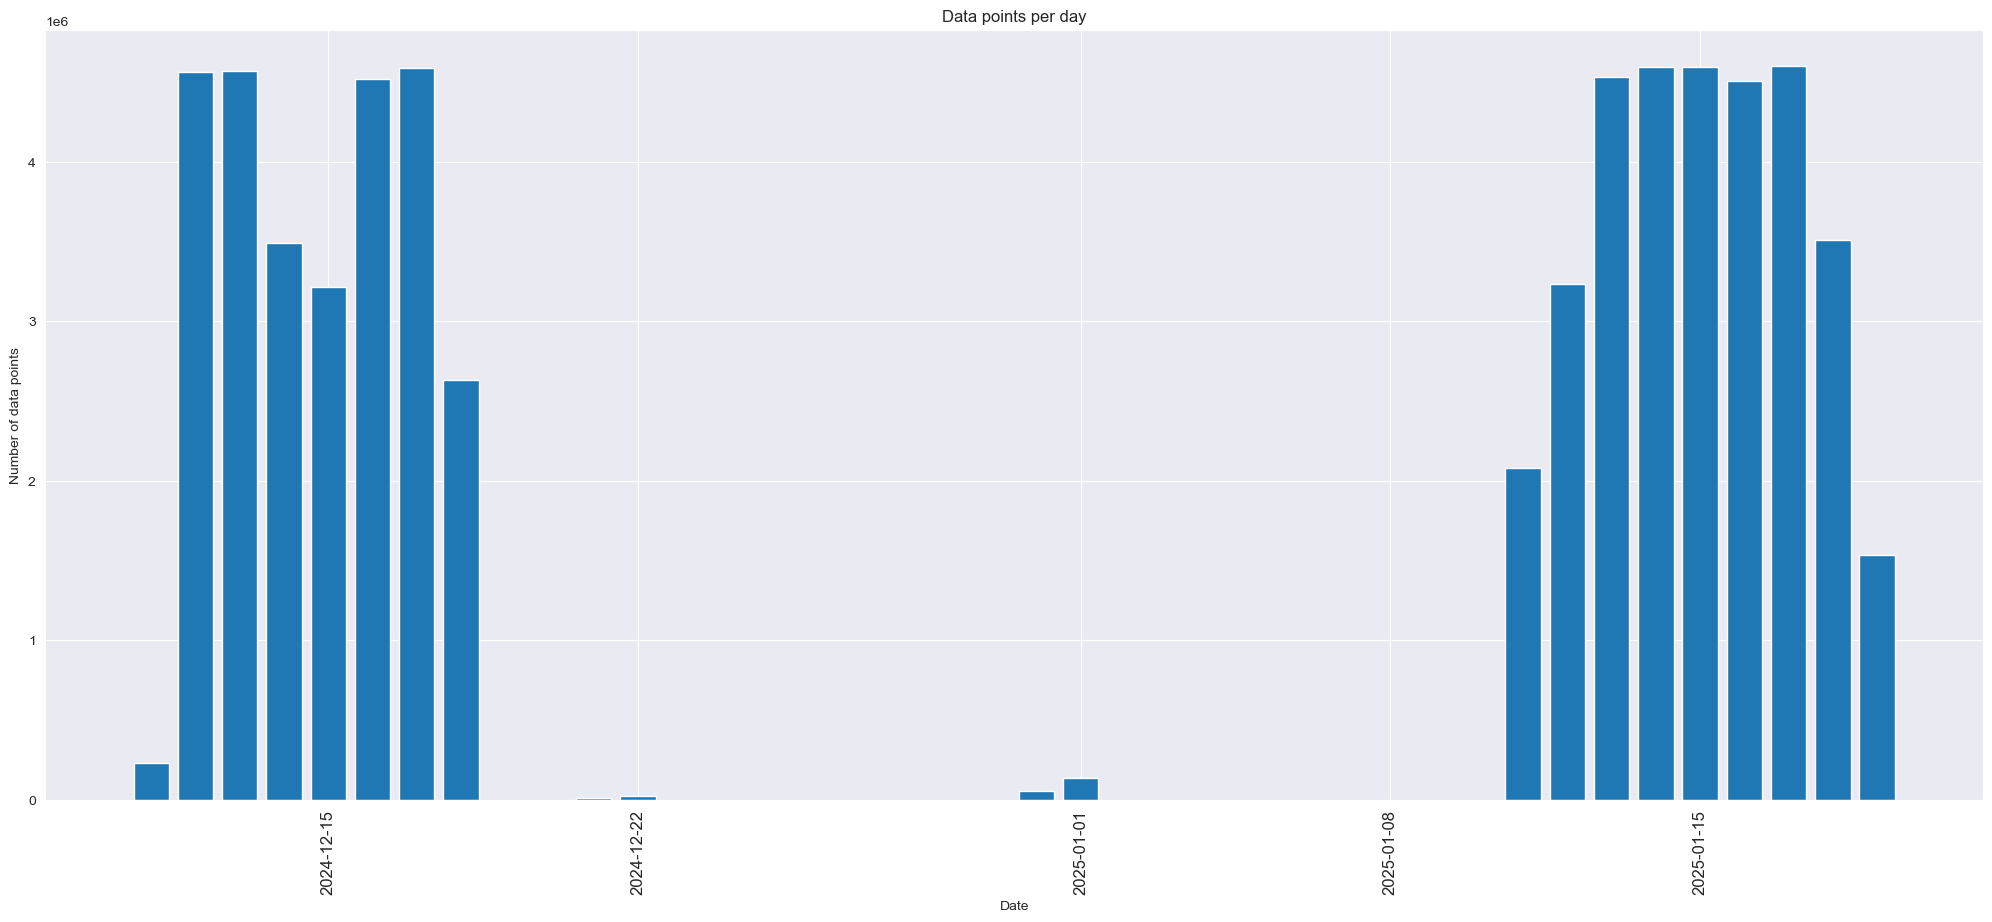

In [8]:
data_points_per_day = df.groupby(df['scheduled_trip_start_time'].dt.date).size()
plt.figure(figsize=(25, 10))
plt.bar(data_points_per_day.index, data_points_per_day.values, width=0.8)
plt.title('Data points per day')
plt.xlabel('Date')
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Number of data points')

There are gaps in data - some days are missing any observations

In [9]:
df.to_parquet("bus_trip_history.parquet")

Let's now connect this data with stop data to get stop names and their locations. For this we are using a second dataset - stops.json

In [10]:
import json
from typing import List, Optional, Dict

class Stop:
    def __init__(self, stopId: int, stopCode: str, stopName: str, stopShortName: str, stopDesc: str,
                 subName: str, date: str, zoneId: int, zoneName: str, virtual: int, nonpassenger: int, depot: int,
                 ticketZoneBorder: int, onDemand: int, activationDate: str, stopLat: float, stopLon: float,
                 stopType: str, stopUrl: str, locationType: Optional[str], parentStation: Optional[str],
                 stopTimezone: Optional[str], wheelchairBoarding: Optional[str]):
        self.stopId = stopId
        self.stopCode = stopCode
        self.stopName = stopName
        self.stopShortName = stopShortName
        self.stopDesc = stopDesc
        self.subName = subName
        self.date = date
        self.zoneId = zoneId
        self.zoneName = zoneName
        self.virtual = virtual
        self.nonpassenger = nonpassenger
        self.depot = depot
        self.ticketZoneBorder = ticketZoneBorder
        self.onDemand = onDemand
        self.activationDate = activationDate
        self.stopLat = stopLat
        self.stopLon = stopLon
        self.stopType = stopType  
        self.stopUrl = stopUrl
        self.locationType = locationType
        self.parentStation = parentStation
        self.stopTimezone = stopTimezone
        self.wheelchairBoarding = wheelchairBoarding

    def __repr__(self):
        return f"Stop({self.stopId}, {self.stopName},{self.stopDesc} {self.stopLat}, {self.stopLon})"


class Data:
    def __init__(self, lastUpdate: str, stops: List[Stop]):
        self.lastUpdate = lastUpdate
        self.stops = stops

    def __repr__(self):
        return f"Data({self.lastUpdate}, {len(self.stops)} stops)"


def load_json_to_objects(file_path: str) -> Dict[int, Stop]:
    with open(file_path, 'r', encoding='utf-8') as f:
        input_data = json.load(f)

    stop_dict = {}

    for date, entry in input_data.items():
        for stop in entry['stops']:
            stop['stopType'] = stop['type']
            del stop['type']
            
            stop_obj = Stop(**stop)
            stop_dict[stop_obj.stopId] = stop_obj

    return stop_dict


file_path = 'D:\PJATK_MGR\projekt\stops.json' 
stop_dict = load_json_to_objects(file_path)


print(stop_dict.get(1024))  # Example: Access stop with stopId 1024`
print(stop_dict.get(1024).stopDesc)
print(len(stop_dict))

Stop(1024, None,Tamka (N/Ż) 54.35912, 18.70535)
Tamka (N/Ż)
2754


In [11]:
def add_stop_info(_df):
    _df['stop_desc'] = _df['stop_id'].apply(lambda stop_id: stop_dict.get(stop_id).stopDesc if stop_id in stop_dict else None)
    _df['stop_lat'] = _df['stop_id'].apply(lambda stop_id: stop_dict.get(stop_id).stopLat if stop_id in stop_dict else None)
    _df['stop_lon'] = _df['stop_id'].apply(lambda stop_id: stop_dict.get(stop_id).stopLon if stop_id in stop_dict else None)
    return _df


Let's now see one bus route.

In [12]:
df_126 = df[df.route_id == 126]

In [13]:
df_126 = add_stop_info(df_126)

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\2763439029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['stop_desc'] = _df['stop_id'].apply(lambda stop_id: stop_dict.get(stop_id).stopDesc if stop_id in stop_dict else None)
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\2763439029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['stop_lat'] = _df['stop_id'].apply(lambda stop_id: stop_dict.get(stop_id).stopLat if stop_id in stop_dict else None)
C:\Users\48514\AppData\Local\Temp\ipykernel_

theoretical_time is the time of bus at the stop. We have many data points per each theoretical time. Let's see how delay evolves over time for each stop for one selected bus line.

In [14]:
def plot_trips_per_day(dataframe):
    dataframe['scheduled_trip_start_time'] = pd.to_datetime(dataframe['scheduled_trip_start_time'], errors='coerce')
    df_cleaned = dataframe.dropna(subset=['scheduled_trip_start_time'])
    
    unique_dates = df_cleaned['scheduled_trip_start_time'].unique()
    np_date = unique_dates.astype('datetime64[D]')
    unique_values, counts = np.unique(np_date, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique_values, counts)
    plt.xticks(rotation=45)
    plt.show()

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\2884110296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['scheduled_trip_start_time'] = pd.to_datetime(dataframe['scheduled_trip_start_time'], errors='coerce')


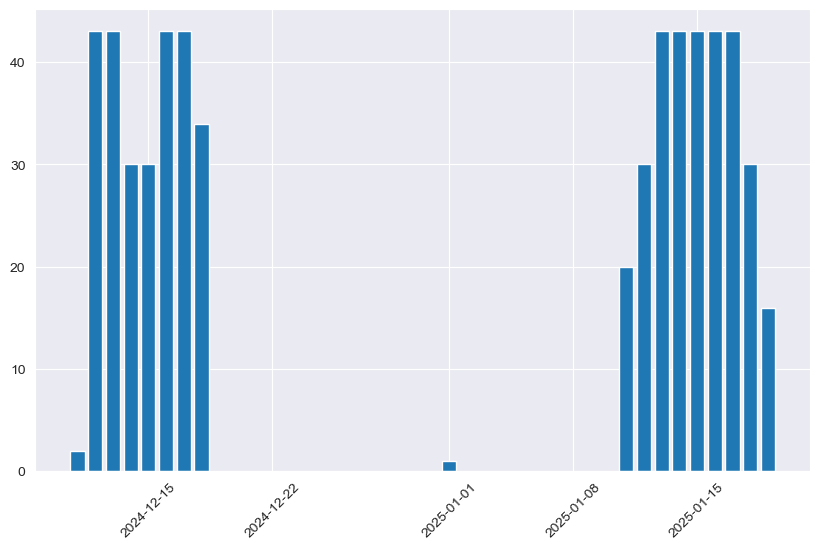

In [15]:
plot_trips_per_day(df_126)

We see a drop in number of trips on 14th and 15th of december - this is a weekend. Let's now group this data by individual trips to reveal pattern.

In [16]:
grouped_by_trip = df_126.groupby('scheduled_trip_start_time')
print(f"Dataset contains {len(grouped_by_trip.groups)} bus trips for line 126.")
for name, group in grouped_by_trip:
    print(f"Group: {name}")
    print(group.shape)

Dataset contains 580 bus trips for line 126.
Group: 2024-12-11 21:00:00
(76, 21)
Group: 2024-12-11 21:43:00
(687, 21)
Group: 2024-12-12 03:38:00
(1529, 21)
Group: 2024-12-12 04:00:00
(1083, 21)
Group: 2024-12-12 04:20:00
(1182, 21)
Group: 2024-12-12 04:31:00
(1334, 21)
Group: 2024-12-12 04:40:00
(1053, 21)
Group: 2024-12-12 04:50:00
(386, 21)
Group: 2024-12-12 05:05:00
(780, 21)
Group: 2024-12-12 05:36:00
(632, 21)
Group: 2024-12-12 05:40:00
(1628, 21)
Group: 2024-12-12 06:06:00
(394, 21)
Group: 2024-12-12 06:30:00
(582, 21)
Group: 2024-12-12 06:39:00
(442, 21)
Group: 2024-12-12 07:00:00
(338, 21)
Group: 2024-12-12 07:25:00
(633, 21)
Group: 2024-12-12 07:30:00
(351, 21)
Group: 2024-12-12 08:00:00
(1469, 21)
Group: 2024-12-12 08:21:00
(583, 21)
Group: 2024-12-12 09:06:00
(1357, 21)
Group: 2024-12-12 09:14:00
(1201, 21)
Group: 2024-12-12 10:01:00
(1038, 21)
Group: 2024-12-12 10:14:00
(802, 21)
Group: 2024-12-12 11:01:00
(638, 21)
Group: 2024-12-12 11:14:00
(735, 21)
Group: 2024-12-12 12:

In [17]:
df_126_12_dec = df_126[df_126.scheduled_trip_start_time == '2024-12-11 21:43:00']
df_126_12_dec.sort_values(['theoretical_time', 'updated_at'])

updated_at  stop_id       id  trip_id  route_id  \
4389   2024-12-11 21:12:47      114  T41R126       41       126   
4900   2024-12-11 21:12:49      313  T41R126       41       126   
6218   2024-12-11 21:14:26      114  T41R126       41       126   
6670   2024-12-11 21:14:28      313  T41R126       41       126   
15369  2024-12-11 21:16:57      114  T41R126       41       126   
...                    ...      ...      ...      ...       ...   
133495 2024-12-11 22:11:04     7982  T41R126       41       126   
136388 2024-12-11 22:12:44     7982  T41R126       41       126   
137467 2024-12-11 22:14:24     7982  T41R126       41       126   
141962 2024-12-11 22:16:54     7982  T41R126       41       126   
143887 2024-12-11 22:18:34     7982  T41R126       41       126   

       route_short_name        headsign scheduled_trip_start_time  \
4389                126  Banino Pszenna       2024-12-11 21:43:00   
4900                126  Banino Pszenna       2024-12-11 21:43:00   
6218                126  Banino Pszenna       2024-12-11 21:43:00   
6670                126  Banino Pszenna       2024-12-11 21:43:00   
15369               126  Banino Pszenna       2024-12-11 21:43:00   
...                 ...             ...                       ...   
133495              126  Banino Pszenna       2024-12-11 21:43:00   
136388              126  Banino Pszenna       2024-12-11 21:43:00   
137467              126  Banino Pszenna       2024-12-11 21:43:00   
141962              126  Banino Pszenna       2024-12-11 21:43:00   
143887              126  Banino Pszenna       2024-12-11 21:43:00   

          theoretical_time      estimated_time  ...    status  \
4389   2024-12-11 21:43:00 2024-12-11 21:43:01  ...  REALTIME   
4900   2024-12-11 21:43:00 2024-12-11 21:43:02  ...  REALTIME   
6218   2024-12-11 21:43:00 2024-12-11 21:43:04  ...  REALTIME   
6670   2024-12-11 21:43:00 2024-12-11 21:43:00  ...  REALTIME   
15369  2024-12-11 21:43:00 2024-12-11 21:43:05  ...  REALTIME   
...                    ...                 ...  ...       ...   
133495 2024-12-11 22:17:00 2024-12-11 22:17:56  ...  REALTIME   
136388 2024-12-11 22:17:00 2024-12-11 22:18:01  ...  REALTIME   
137467 2024-12-11 22:17:00 2024-12-11 22:18:11  ...  REALTIME   
141962 2024-12-11 22:17:00 2024-12-11 22:17:56  ...  REALTIME   
143887 2024-12-11 22:17:00 2024-12-11 22:18:59  ...  REALTIME   

                 timestamp       downloaded_at vehicle_code  vehicle_id  \
4389   2024-12-11 21:12:47 2024-12-11 21:14:02       8510.0    145646.0   
4900   2024-12-11 21:12:47 2024-12-11 21:14:02       8510.0    145646.0   
6218   2024-12-11 21:14:23 2024-12-11 21:16:05       8510.0    145646.0   
6670   2024-12-11 21:14:28 2024-12-11 21:16:05       8510.0    145646.0   
15369  2024-12-11 21:16:53 2024-12-11 21:18:04       8510.0    145646.0   
...                    ...                 ...          ...         ...   
133495 2024-12-11 22:11:03 2024-12-11 22:12:05       8510.0    145646.0   
136388 2024-12-11 22:12:44 2024-12-11 22:14:05       8510.0    145646.0   
137467 2024-12-11 22:14:23 2024-12-11 22:16:03       8510.0    145646.0   
141962 2024-12-11 22:16:54 2024-12-11 22:18:05       8510.0    145646.0   
143887 2024-12-11 22:18:28 2024-12-11 22:20:03       8510.0    145646.0   

        vehicle_service     trip       stop_desc  stop_lat  stop_lon  
4389             126-04  4443369    Wrzeszcz PKP  54.38130  18.60453  
4900             126-04  4443369    Wrzeszcz PKP  54.38186  18.60379  
6218             126-04  4443369    Wrzeszcz PKP  54.38130  18.60453  
6670             126-04  4443369    Wrzeszcz PKP  54.38186  18.60379  
15369            126-04  4443369    Wrzeszcz PKP  54.38130  18.60453  
...                 ...      ...             ...       ...       ...  
133495           126-04  4443369  Banino Pszenna  54.39337  18.38498  
136388           126-04  4443369  Banino Pszenna  54.39337  18.38498  
137467           126-04  4443369  Banino Pszenna  54.39337  1

There are many data points per each bus stop, let's see how delay evolves over time for each stop.

Trip contains 26 stops.
Group: Agrarna, theoretical time: 2024-12-11 21:58:00


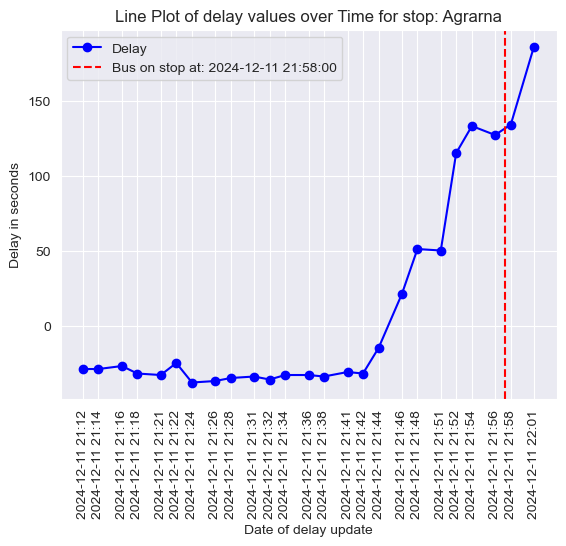

Group: Banino Borowiecka, theoretical time: 2024-12-11 22:15:00


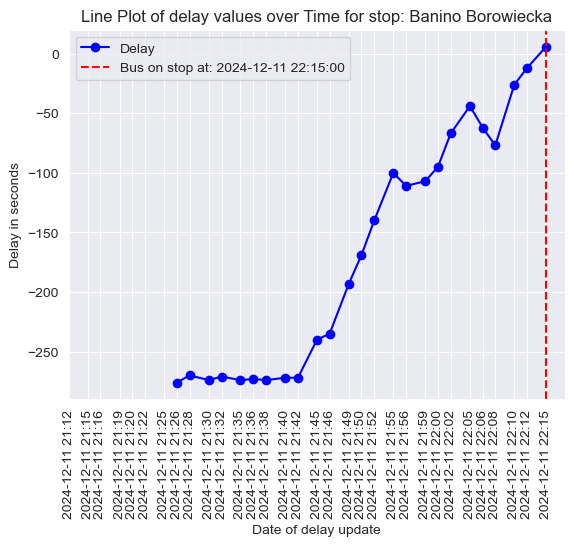

Group: Banino Pszenna, theoretical time: 2024-12-11 22:17:00


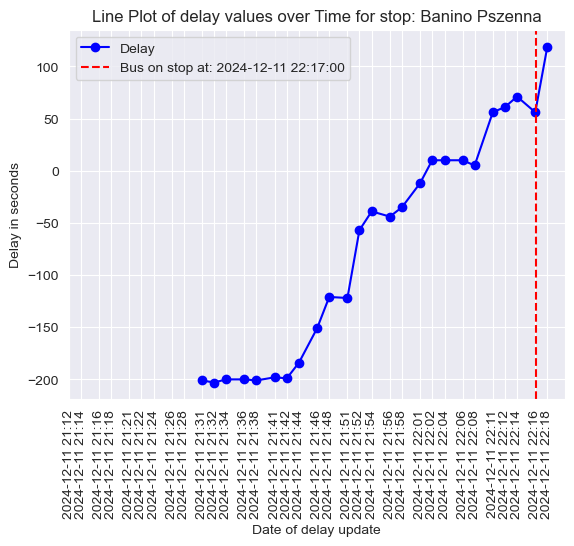

Group: Banino Szkoła, theoretical time: 2024-12-11 22:14:00


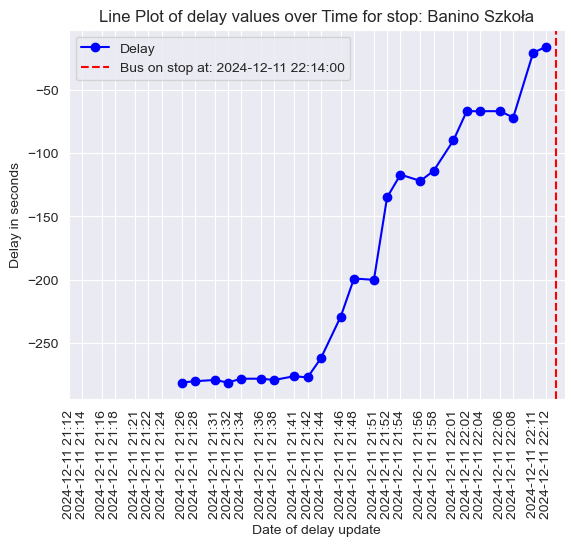

Group: Budowlanych, theoretical time: 2024-12-11 22:01:00


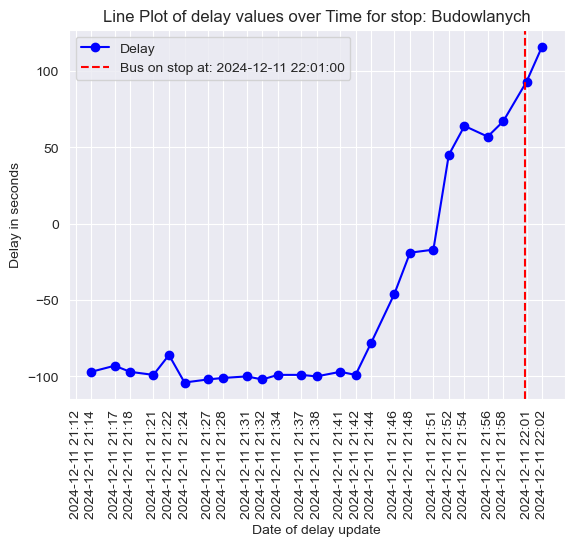

Group: Bysewo (N/Ż), theoretical time: 2024-12-11 22:07:00


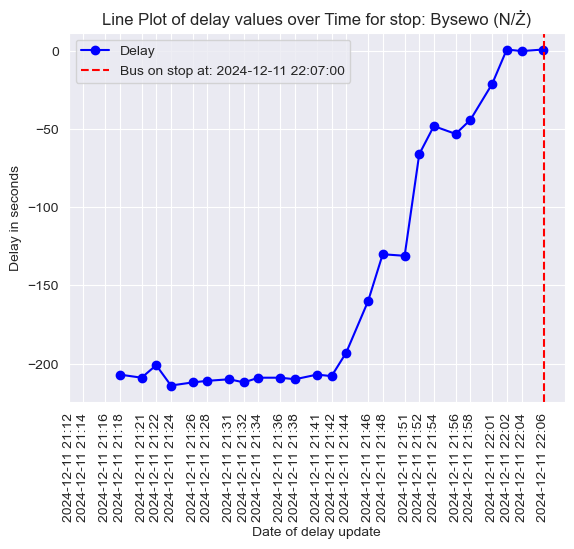

Group: Cmentarz Srebrzysko, theoretical time: 2024-12-11 21:49:00


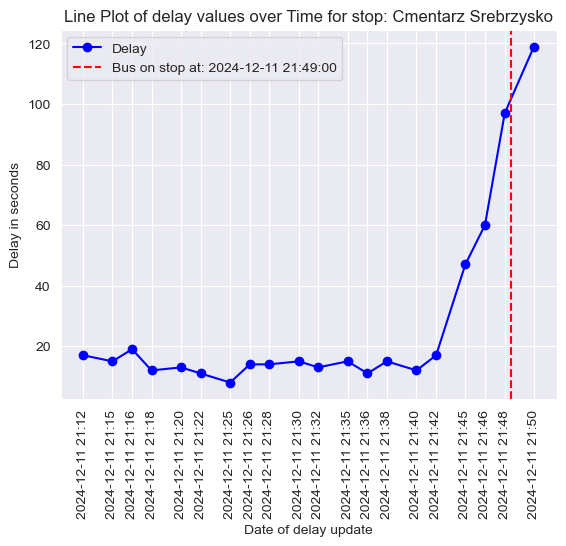

Group: Galeria Bałtycka, theoretical time: 2024-12-11 21:45:00


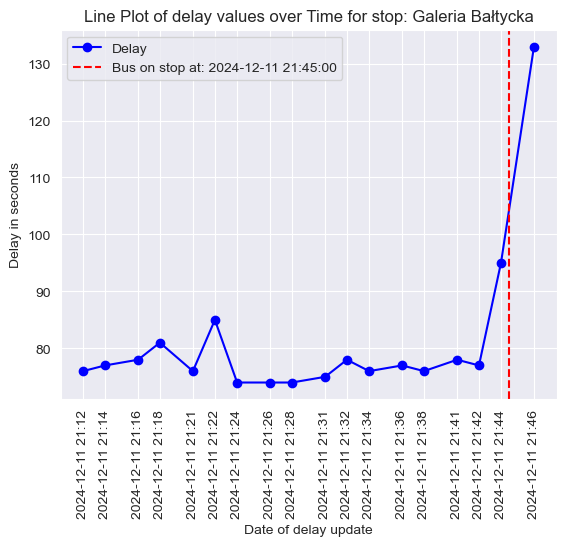

Group: Harfowa, theoretical time: 2024-12-11 21:56:00


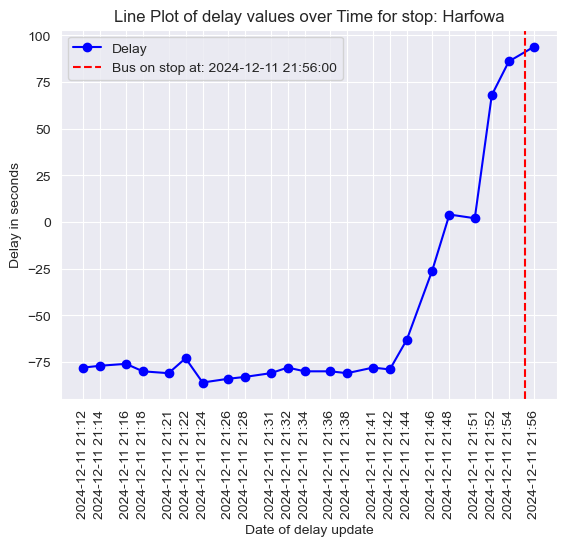

Group: Kosmonautów (N/Ż), theoretical time: 2024-12-11 22:05:00


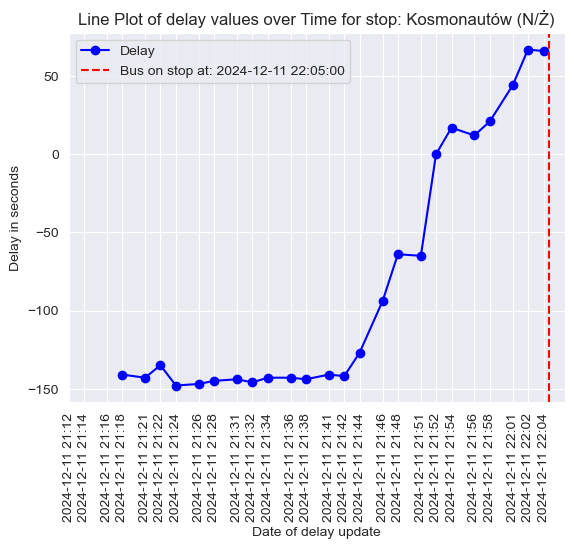

Group: Matarnia PKM, theoretical time: 2024-12-11 21:59:00


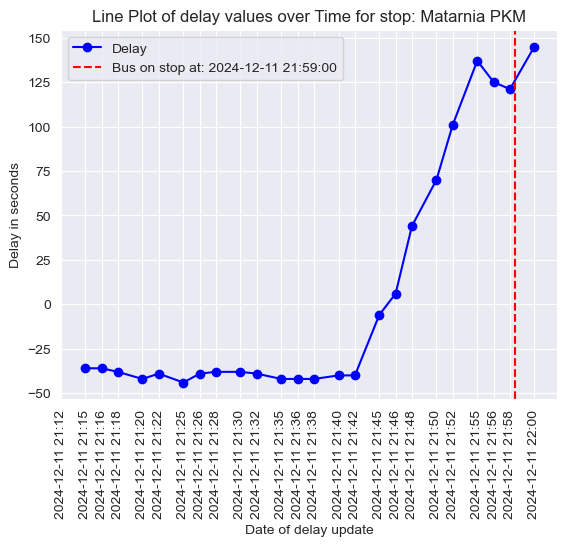

Group: Niedźwiednik PKM (N/Ż), theoretical time: 2024-12-11 21:50:00


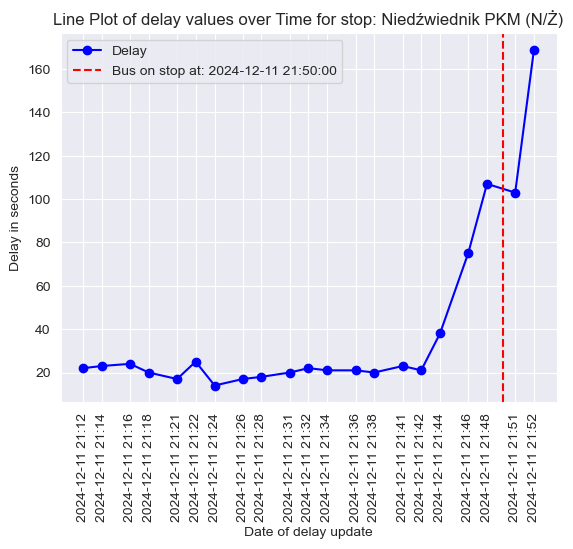

Group: Nowatorów, theoretical time: 2024-12-11 22:02:00


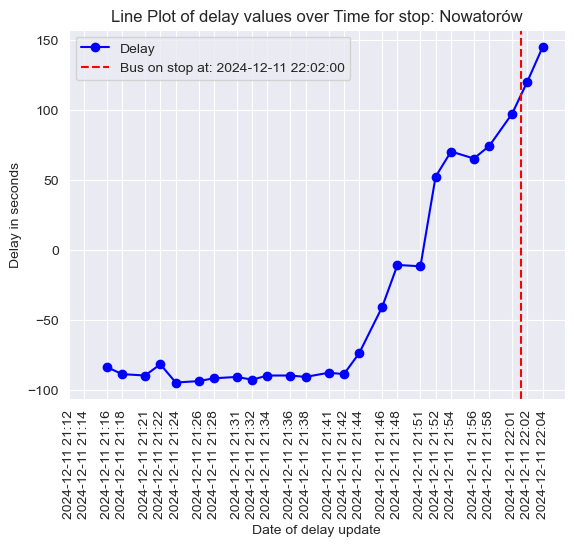

Group: Ogrody Działkowe "Rębiechowo" I (N/Ż), theoretical time: 2024-12-11 22:09:00


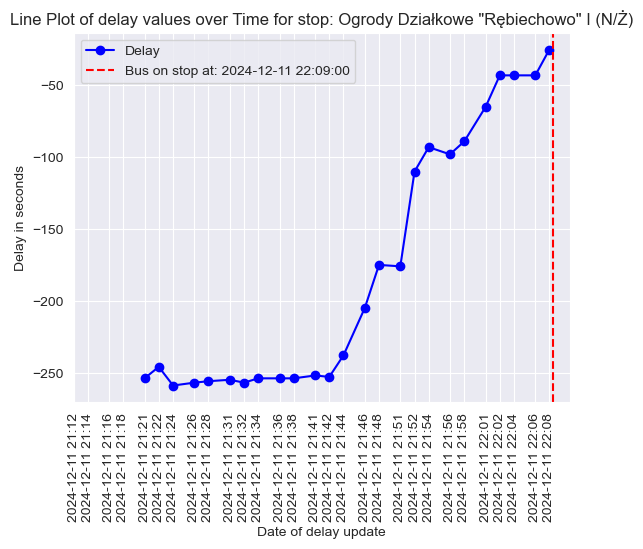

Group: Ogrody Działkowe "Rębiechowo" II (N/Ż), theoretical time: 2024-12-11 22:08:00


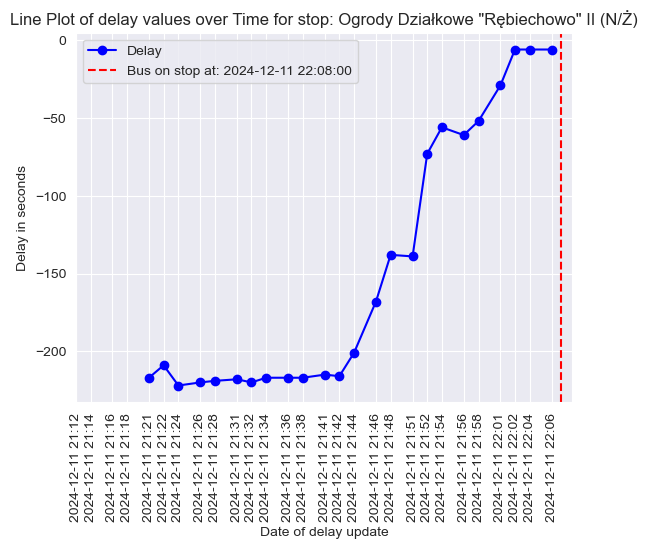

Group: Ogrody Działkowe "Rębiechowo" III (N/Ż), theoretical time: 2024-12-11 22:06:00


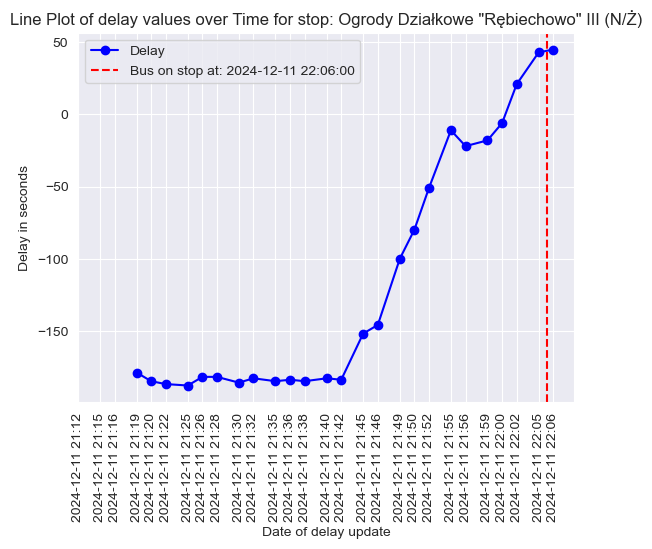

Group: Potokowa, theoretical time: 2024-12-11 21:51:00


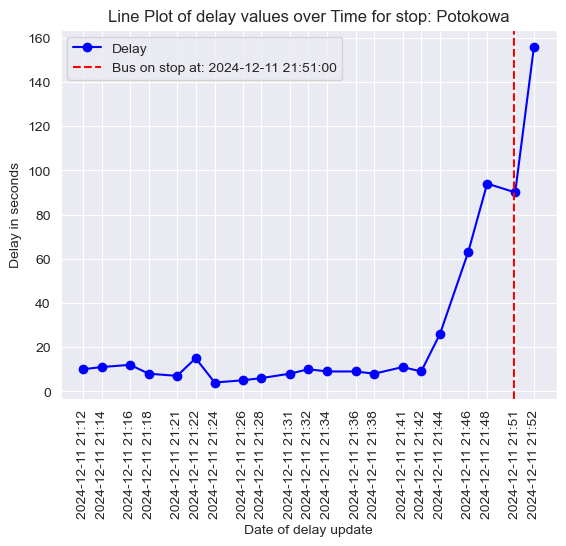

Group: Przyrodników, theoretical time: 2024-12-11 22:11:00


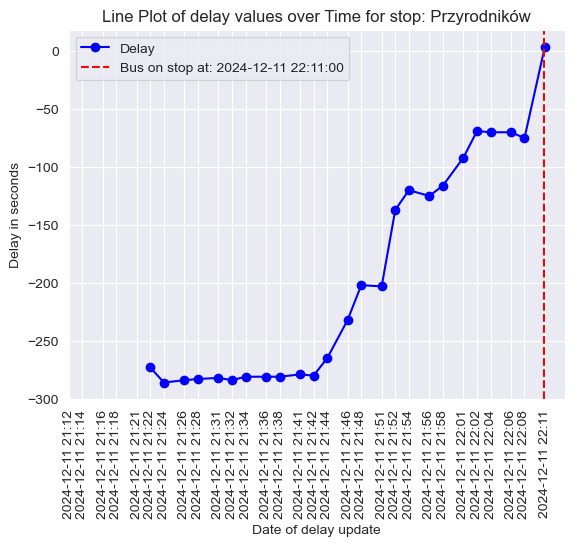

Group: Rakietowa (N/Ż), theoretical time: 2024-12-11 22:04:00


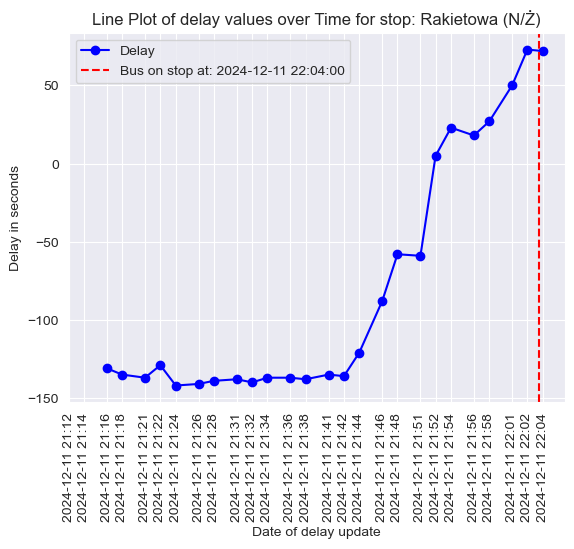

Group: Rębiechowo PKP (N/Ż), theoretical time: 2024-12-11 22:13:00


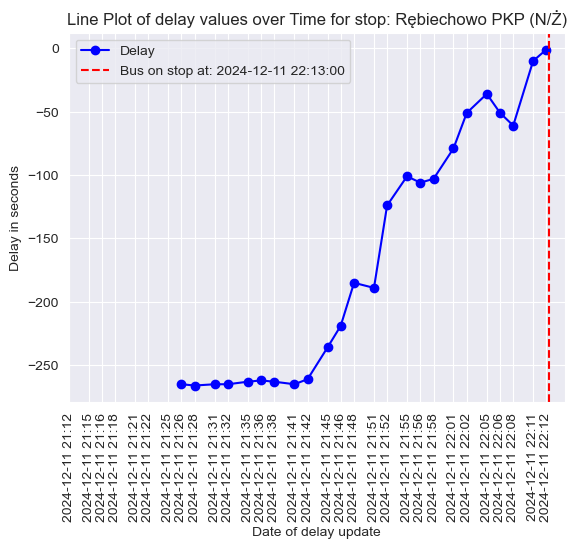

Group: Rębiechowo Piaskowa, theoretical time: 2024-12-11 22:12:00


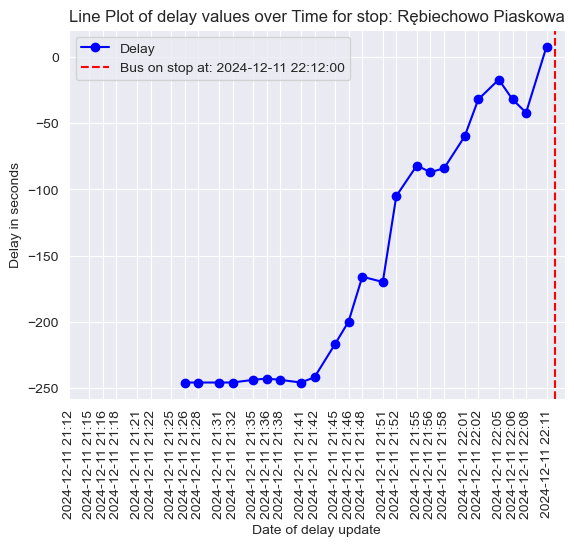

Group: Sąsiedzka (N/Ż), theoretical time: 2024-12-11 22:00:00


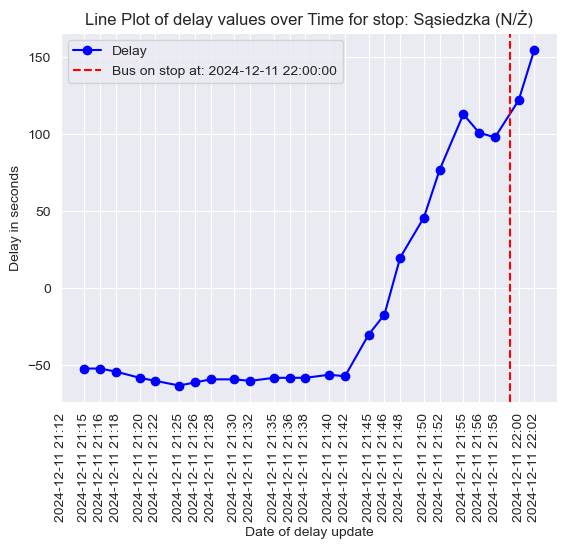

Group: Słowackiego Działki (N/Ż), theoretical time: 2024-12-11 21:53:00


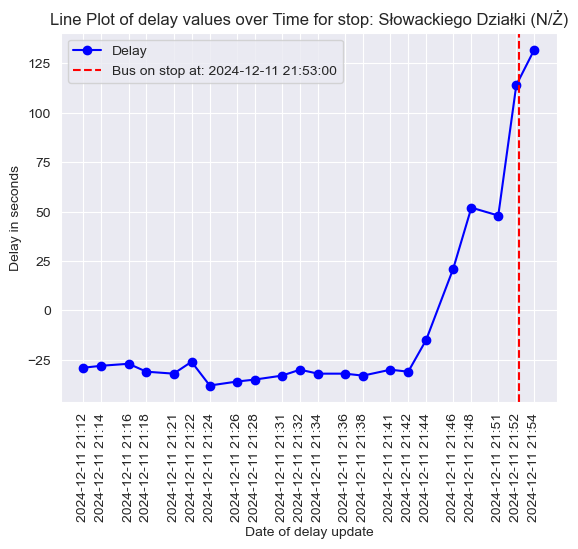

Group: Wrzeszcz PKP, theoretical time: 2024-12-11 21:43:00


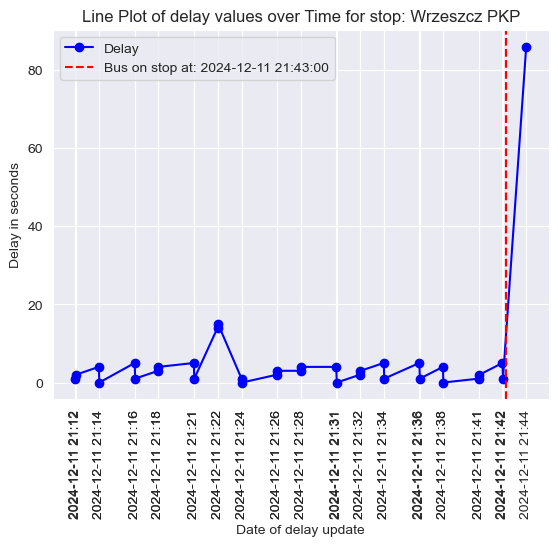

Group: Zabytkowa, theoretical time: 2024-12-11 21:47:00


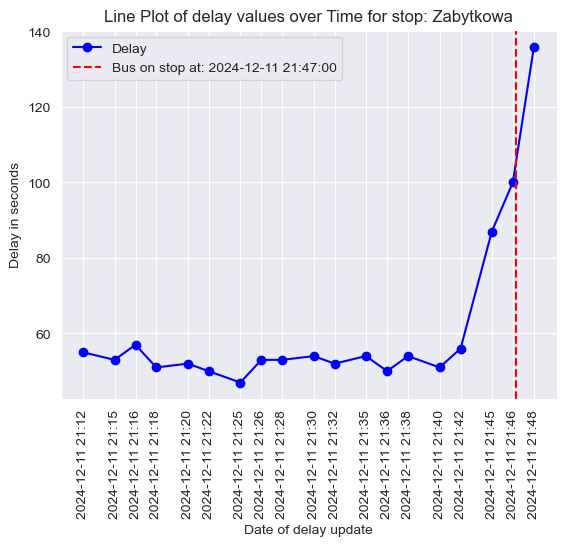

Group: Zbieżna (N/Ż), theoretical time: 2024-12-11 22:03:00


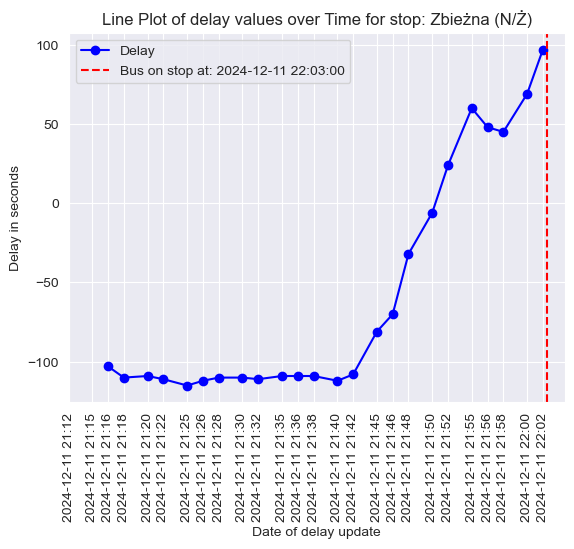

In [18]:
grouped_by_stop = df_126_12_dec.groupby('stop_desc')
print(f"Trip contains {len(grouped_by_stop.groups)} stops.")
for name, group in grouped_by_stop:
    date_on_stop = pd.to_datetime(group.theoretical_time.iloc[0])
    print(f"Group: {name}, theoretical time: {date_on_stop}")
    group['updated_at'] = pd.to_datetime(group['updated_at'])

    plt.plot(group['updated_at'], group['delay_in_seconds'], marker='o', linestyle='-', color='b', label='Delay')
    plt.axvline(x=date_on_stop, color='r', linestyle='--', label=f'Bus on stop at: {date_on_stop}')
    plt.xlabel('Date of delay update')
    plt.ylabel('Delay in seconds')
    plt.title(f'Line Plot of delay values over Time for stop: {name}')
    
    plt.legend()
    plt.xticks(group['updated_at'], rotation=90)  
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    plt.show()

It appears that in all cases the prediction of delay time fluctuates over time but grows. The true delay value is one at the time when bus is on the stop (red line) or just one before that. Some stops (Potokowa) are bound to be delayed as the value of delay is always positive no matter the prediction time. For other stops, the amplitude can be as great as 3-4 minutes. 

From the graphs, we can also see that the prediction of delay is not very accurate even 10 minutes into the future. Let's use the last value as our ground truth.

In [19]:
df_126['updated_at'] = pd.to_datetime(df_126['updated_at'])

df_126 = df_126.sort_values(by=['scheduled_trip_start_time', 'theoretical_time', 'stop_id', 'updated_at'], ascending=[True, True, True, False])
df_126_filtered = df_126.drop_duplicates(subset=['scheduled_trip_start_time', 'theoretical_time', 'stop_id'], keep='first')

df_126_filtered.shape


C:\Users\48514\AppData\Local\Temp\ipykernel_2712\331060159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_126['updated_at'] = pd.to_datetime(df_126['updated_at'])


(15792, 21)

Now we can check the statistics for delays per each stop - we're grouping not only by stop but also by lat, lon to see if there are any patterns in the delay for both directions of a route.

In [20]:
df_126_filtered_no_missing_values = df_126_filtered.replace(r'\\N', None, regex=True, inplace=False)
df_126_filtered_no_missing_values['delay_in_seconds'] = pd.to_numeric(df_126_filtered_no_missing_values['delay_in_seconds'])
avg_delay_per_stop = df_126_filtered_no_missing_values.groupby(['stop_desc', 'stop_lat', 'stop_lon']).delay_in_seconds.mean()
avg_delay_per_stop

stop_desc               stop_lat  stop_lon
Agrarna                 54.37603  18.50798     67.304762
                        54.37628  18.50972     70.308943
Banino Borowiecka       54.39303  18.40294     67.887755
                        54.39319  18.40319     50.285714
Banino Pszenna          54.39337  18.38498    366.683871
                                                 ...    
Żukowo Dworcowa         54.34870  18.36719     64.225000
Żukowo Słoneczna (N/Ż)  54.35963  18.36464    362.688889
                        54.36121  18.36468     80.675000
Żukowo Urząd Gminy      54.34144  18.35514    572.185185
                        54.34212  18.35777     19.225000
Name: delay_in_seconds, Length: 65, dtype: float64

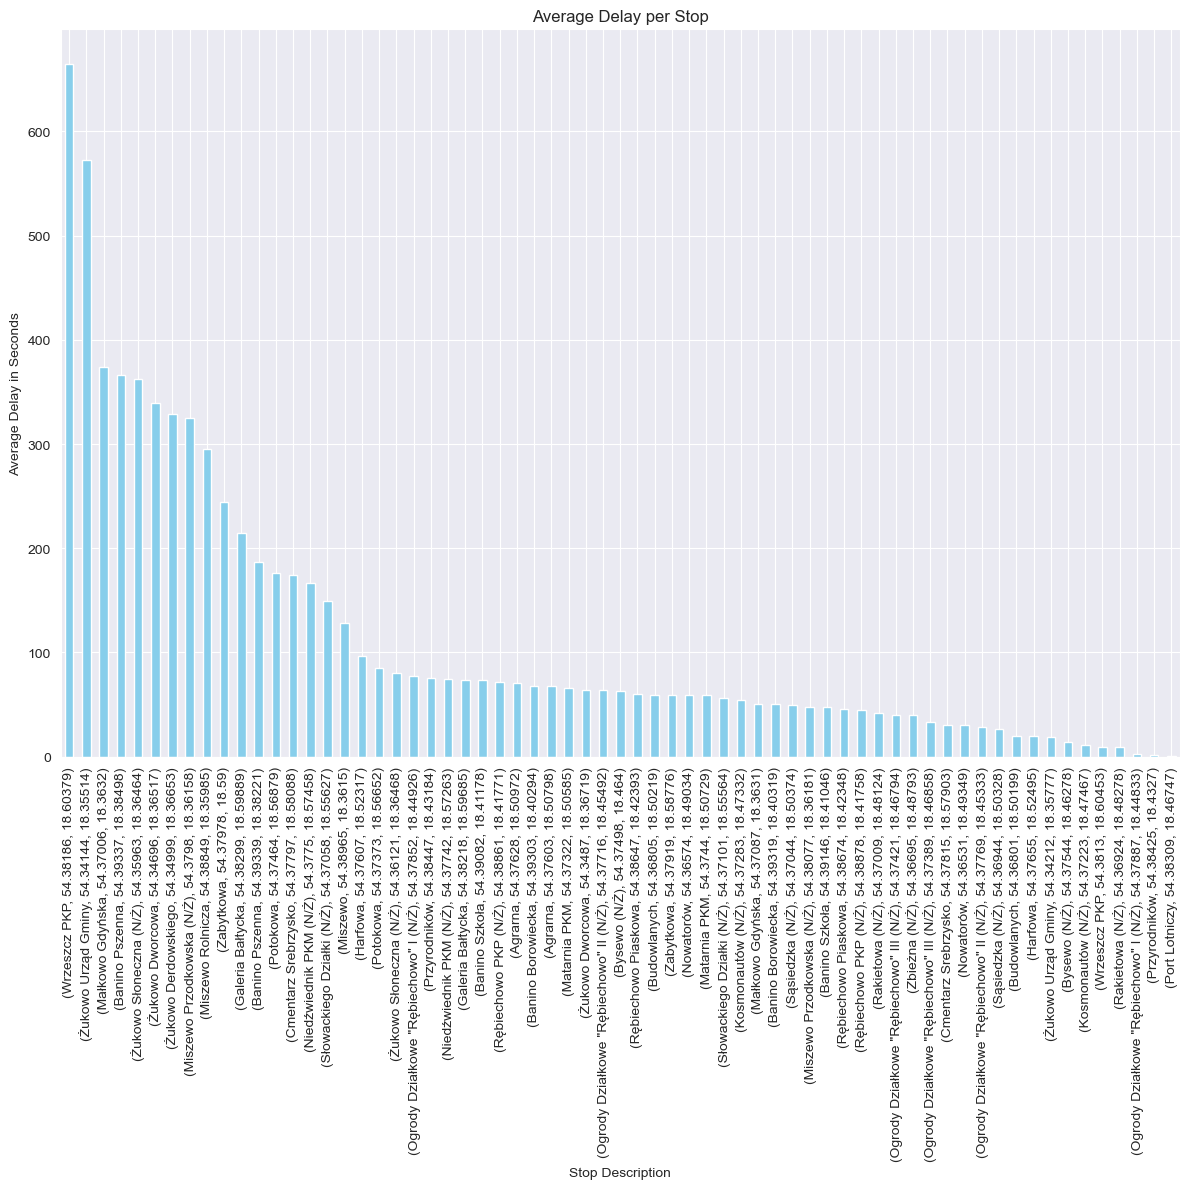

In [21]:
plt.figure(figsize=(12, 12))
avg_delay_per_stop_sorted = avg_delay_per_stop.sort_values(ascending=False)
avg_delay_per_stop_sorted.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Stop Description')
plt.ylabel('Average Delay in Seconds')
plt.title('Average Delay per Stop')
plt.tight_layout()
plt.show()


Each stop has two different versions defined by lat, lon - this allows us to see patterns per each individual stop. Stops with (N/Ż) generate low average delay. Those stops are per request - so the bus does not always need to stop at them. The highest average delay is on the terminate stops (Wrzeszcz PKP, Żukowo Urząd Gminy or Banino Pszenna for shortened route). Let's display them on a map to see which parts of the route generate the most delay.

In [22]:
avg_delay_per_stop_df = avg_delay_per_stop.reset_index()
avg_delay_per_stop_df

stop_desc  stop_lat  stop_lon  delay_in_seconds
0                  Agrarna  54.37603  18.50798         67.304762
1                  Agrarna  54.37628  18.50972         70.308943
2        Banino Borowiecka  54.39303  18.40294         67.887755
3        Banino Borowiecka  54.39319  18.40319         50.285714
4           Banino Pszenna  54.39337  18.38498        366.683871
..                     ...       ...       ...               ...
60         Żukowo Dworcowa  54.34870  18.36719         64.225000
61  Żukowo Słoneczna (N/Ż)  54.35963  18.36464        362.688889
62  Żukowo Słoneczna (N/Ż)  54.36121  18.36468         80.675000
63      Żukowo Urząd Gminy  54.34144  18.35514        572.185185
64      Żukowo Urząd Gminy  54.34212  18.35777         19.225000

[65 rows x 4 columns]

In [23]:
map_center = [avg_delay_per_stop_df['stop_lat'].mean(), avg_delay_per_stop_df['stop_lon'].mean()]
print(f"Smallest average delay: {avg_delay_per_stop_df['delay_in_seconds'].min()}, highest_average_delay: {avg_delay_per_stop_df['delay_in_seconds'].max()}")
m = folium.Map(map_center,zoom_start=12)
for index, row in avg_delay_per_stop_df.iterrows():
    if row['delay_in_seconds'] < 0:
        color = 'purple'
    elif row['delay_in_seconds'] == 0:
        color='green'
    elif row['delay_in_seconds'] < 120:
        color='lightred'
    else:
        color="red"
    folium.Marker(
        location=[row['stop_lat'], row['stop_lon']],
        popup=f"{row['stop_desc']}<br>Delay: {row['delay_in_seconds']} s",
        icon=folium.Icon(color=color)
    ).add_to(m)

m

Smallest average delay: 1.0, highest_average_delay: 664.7223880597015


The most congested parts of the route are in Żukowo and Wrzeszcz. Usually, the bus is late on almost all its stops. I'm a domain expert when it comes to this bus and can confirm this pattern is valid ;) But maybe it's not all that bad - let's take a look at individual trips and analyze per-stop delay. We'll look at each direction separately. There is one stop that seems to be wrongly matched - Port Lotniczy, it is off the route.

In [24]:
df_126_filtered_to_wrzeszcz = df_126_filtered_no_missing_values[df_126_filtered_no_missing_values.headsign == 'Wrzeszcz PKP']
df_126_filtered_to_wrzeszcz

updated_at  stop_id       id  trip_id  route_id  \
4258     2024-12-11 21:12:46     1416  T52R126       52       126   
5993     2024-12-11 21:14:25     1414  T52R126       52       126   
7205     2024-12-11 21:14:30    15021  T52R126       52       126   
9274     2024-12-11 21:15:05     1844  T52R126       52       126   
13230    2024-12-11 21:16:48    14554  T52R126       52       126   
...                      ...      ...      ...      ...       ...   
61164033 2025-01-19 12:03:21     1926  T52R126       52       126   
61164022 2025-01-19 12:03:21     1924  T52R126       52       126   
61164011 2025-01-19 12:03:21     1922  T52R126       52       126   
61166132 2025-01-19 12:03:32     1382  T52R126       52       126   
61167067 2025-01-19 12:03:36      313  T52R126       52       126   

         route_short_name      headsign scheduled_trip_start_time  \
4258                  126  Wrzeszcz PKP       2024-12-11 21:00:00   
5993                  126  Wrzeszcz PKP       2024-12-11 21:00:00   
7205                  126  Wrzeszcz PKP       2024-12-11 21:00:00   
9274                  126  Wrzeszcz PKP       2024-12-11 21:00:00   
13230                 126  Wrzeszcz PKP       2024-12-11 21:00:00   
...                   ...           ...                       ...   
61164033              126  Wrzeszcz PKP       2025-01-19 12:21:00   
61164022              126  Wrzeszcz PKP       2025-01-19 12:21:00   
61164011              126  Wrzeszcz PKP       2025-01-19 12:21:00   
61166132              126  Wrzeszcz PKP       2025-01-19 12:21:00   
61167067              126  Wrzeszcz PKP       2025-01-19 12:21:00   

            theoretical_time      estimated_time  ...     status  \
4258     2024-12-11 21:13:00 2024-12-11 21:12:46  ...   REALTIME   
5993     2024-12-11 21:15:00 2024-12-11 21:14:34  ...   REALTIME   
7205     2024-12-11 21:16:00 2024-12-11 21:15:48  ...   REALTIME   
9274     2024-12-11 21:17:00 2024-12-11 21:15:54  ...   REALTIME   
13230    2024-12-11 21:18:00 2024-12-11 21:17:21  ...   REALTIME   
...                      ...                 ...  ...        ...   
61164033 2025-01-19 12:49:00 2025-01-19 12:44:25  ...   REALTIME   
61164022 2025-01-19 12:50:00 2025-01-19 12:45:16  ...   REALTIME   
61164011 2025-01-19 12:51:00 2025-01-19 12:46:46  ...   REALTIME   
61166132 2025-01-19 12:53:00 2025-01-19 12:53:00  ...  SCHEDULED   
61167067 2025-01-19 12:54:00 2025-01-19 12:54:00  ...  SCHEDULED   

                   timestamp       downloaded_at vehicle_code  vehicle_id  \
4258     2024-12-11 21:11:53 2024-12-11 21:14:02       8510.0    145646.0   
5993     2024-12-11 21:14:23 2024-12-11 21:16:05       8510.0    145646.0   
7205     2024-12-11 21:14:30 2024-12-11 21:16:05       8510.0    145646.0   
9274     2024-12-11 21:15:01 2024-12-11 21:16:05       8510.0    145646.0   
13230    2024-12-11 21:16:48 2024-12-11 21:18:04       8510.0    145646.0   
...                      ...                 ...          ...         ...   
61164033 2025-01-19 12:03:19 2025-01-19 12:04:02       8505.0    145641.0   
61164022 2025-01-19 12:03:19 2025-01-19 12:04:02       8505.0    145641.0   
61164011 2025-01-19 12:03:19 2025-01-19 12:04:02       8505.0    145641.0   
61166132 2025-01-19 12:03:32 2025-01-19 12:04:02          NaN         NaN   
61167067 2025-01-19 12:03:36 2025-01-19 12:04:02          NaN         NaN   

          vehicle_service     trip               stop_desc  stop_lat  stop_lon  
4258               126-04  4443368         Rakietowa (N/Ż)  54.36924  18.48278  
5993               126-04  4443368               Nowatorów  54.36531  18.49349  
7205               126-04  4443368             Budowlanych  54.36805  18.50219  
9274               126-04  4443368         Sąsiedzka (N/Ż)  54.36944  18.50328  
13230              126-04  4443368            Matarnia PKM  54.37440  18.50729  
...                   ...      ...                     ...       ...       ...  
61164033           126-02  5719202  Niedźwiednik PK

Let's filter out trip with missing data. 4443368 starts with Rakietowa stop - which is halfway in the route.

In [25]:
df_126_filtered_to_wrzeszcz = df_126_filtered_to_wrzeszcz[df_126_filtered_to_wrzeszcz.trip != 4443368]

In [26]:
ordered_stops_zukowo = list(df_126_filtered_to_wrzeszcz.sort_values(['scheduled_trip_start_time', 'theoretical_time']).stop_desc)[26:57]
ordered_stops_banino = list(df_126_filtered_to_wrzeszcz.sort_values(['scheduled_trip_start_time', 'theoretical_time']).stop_desc)[32:57]

In [27]:
def plot_delay_per_stop_for_many_trips(df_to_plot, stops_len):
    df_to_plot['scheduled_trip_start_time'] = pd.to_datetime(df_to_plot['scheduled_trip_start_time'])
    df_to_plot['theoretical_time'] = pd.to_datetime(df_to_plot['theoretical_time'], errors='coerce')
    df_to_plot['delay_in_seconds'] = pd.to_numeric(df_to_plot['delay_in_seconds'], errors='coerce')
    
    grouped_trips = df_to_plot.groupby('scheduled_trip_start_time')
    
    plt.figure(figsize=(14, 8))
    
    for trip_time, group in grouped_trips:
        group_sorted = group.sort_values(by='theoretical_time')
        
        
        if not len(group_sorted['stop_desc']) == stops_len:
            continue
            
    
        plt.plot(
            group_sorted['stop_desc'], 
            group_sorted['delay_in_seconds'],  
            marker='o',  
            linestyle='-',  
            label=f'{trip_time.strftime("%Y-%m-%d %H:%M")}' 
        )
    
    plt.xlabel('Stop Description')
    plt.ylabel('Delay in Seconds')
    plt.title('Delays per Stop for Multiple Trips')
    plt.xticks(rotation=90)  
    plt.tight_layout()
    
    plt.show()

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\804353327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['scheduled_trip_start_time'] = pd.to_datetime(df_to_plot['scheduled_trip_start_time'])
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\804353327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['theoretical_time'] = pd.to_datetime(df_to_plot['theoretical_time'], errors='coerce')
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\804353327.py:4: SettingWithCopyWarning: 
A val

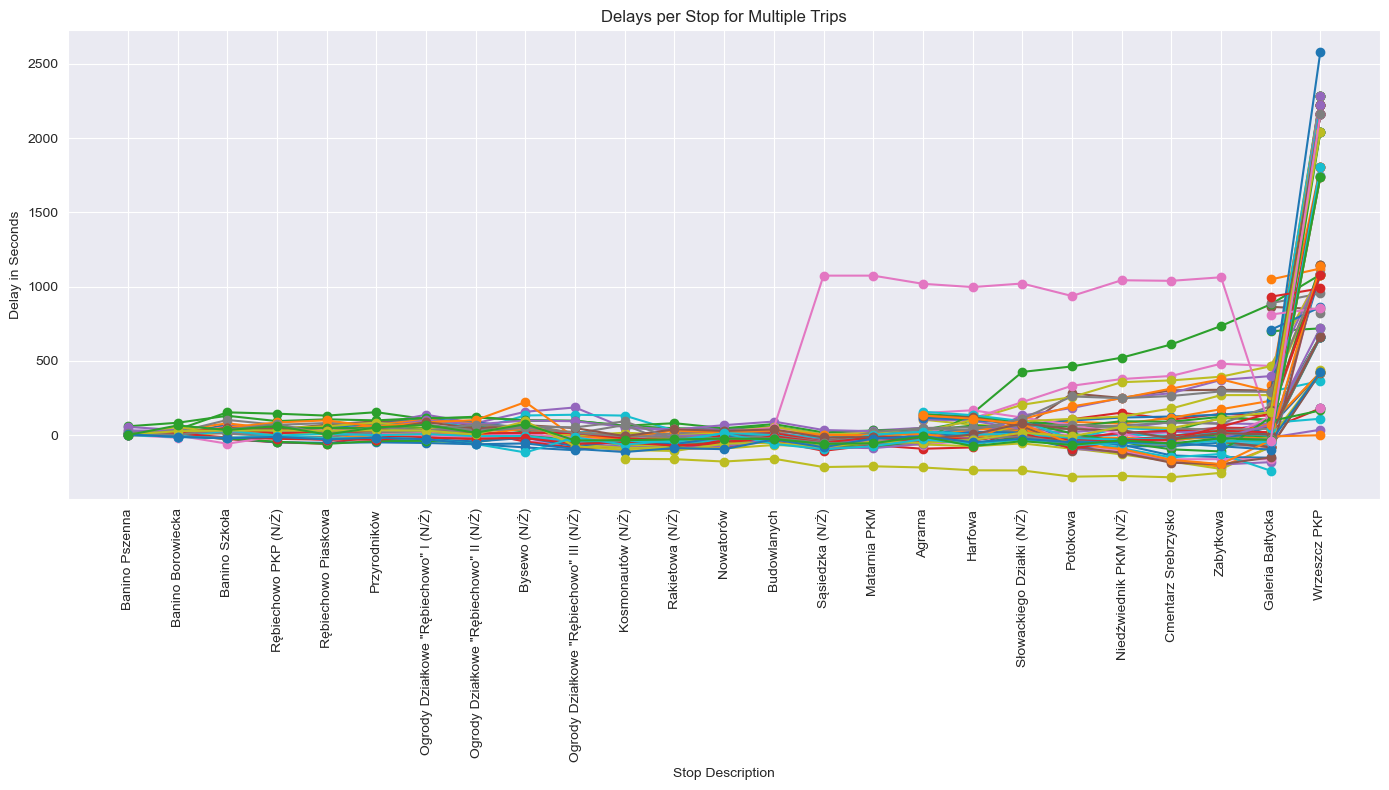

In [28]:
plot_delay_per_stop_for_many_trips(df_to_plot=df_126_filtered_to_wrzeszcz, stops_len=25)


We can see that for trips going from Banino the delay starts to build up significantly after Harfowa stop. There may be some outliers - the trips with 2000-2500s of delay.

Let's now take a look at delay pattern per trip in the other direction.

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\804353327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['scheduled_trip_start_time'] = pd.to_datetime(df_to_plot['scheduled_trip_start_time'])
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\804353327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['theoretical_time'] = pd.to_datetime(df_to_plot['theoretical_time'], errors='coerce')
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\804353327.py:4: SettingWithCopyWarning: 
A val

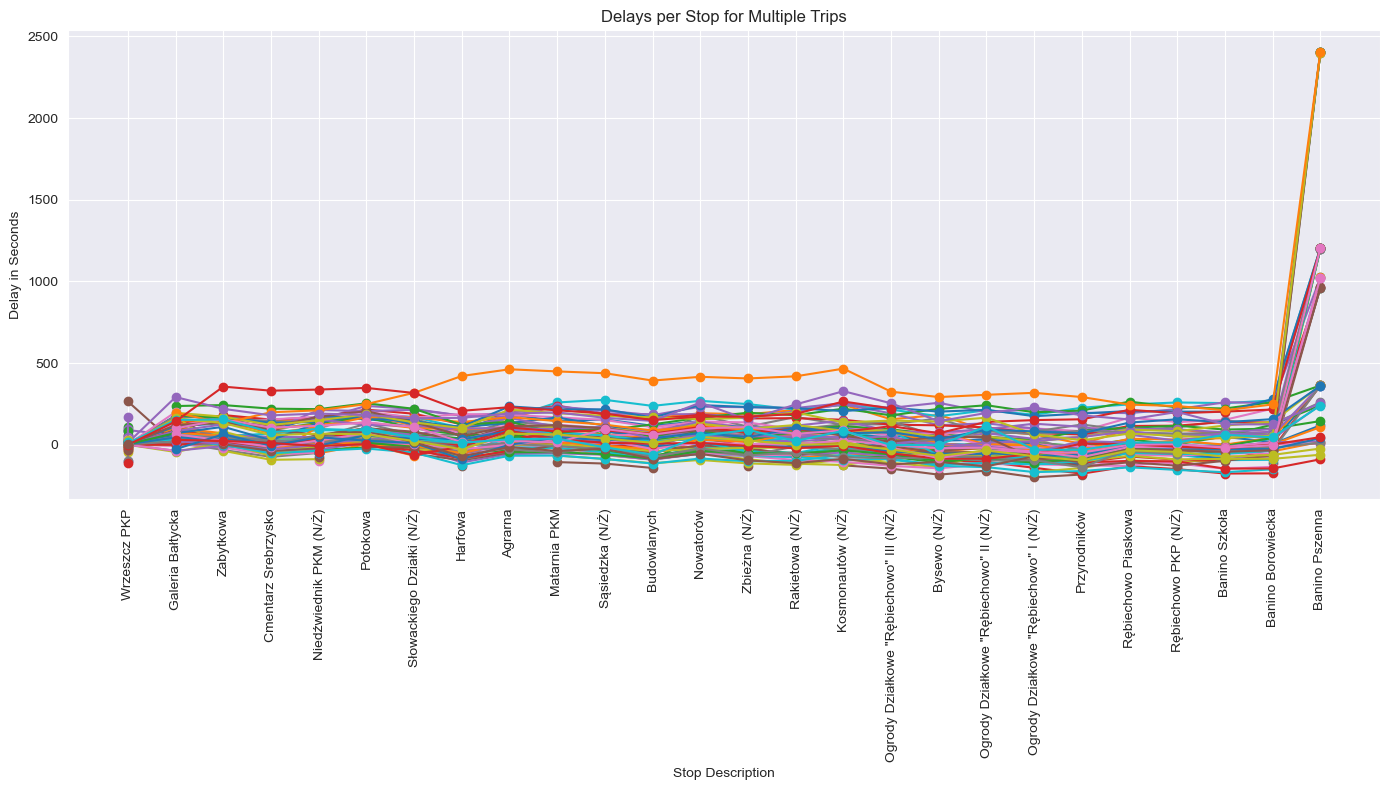

In [29]:
df_126_filtered_to_banino = df_126_filtered_no_missing_values[df_126_filtered_no_missing_values.headsign == 'Banino Pszenna']
ordered_stops_banino_a = ["Wrzeszcz PKP", "a"]
ordered_stops_banino_a.extend(ordered_stops_banino[::-1])
plot_delay_per_stop_for_many_trips(df_to_plot=df_126_filtered_to_banino, stops_len=27)


This time pattern is slightly different - delay builds up evenly across the entire route. There might be a few outliers with ~ 2k seconds delay.

Let's now look for patterns in the entire dataset - are there bus lines that are on average more delayed than others?

In [30]:
df_preprocessed = df.sort_values(by=['route_id', 'scheduled_trip_start_time', 'theoretical_time', 'stop_id', 'updated_at'], ascending=[True, True, True, True, False])
df_preprocessed = df_preprocessed.drop_duplicates(subset=['scheduled_trip_start_time', 'theoretical_time', 'stop_id', 'route_id'], keep='first')

df_preprocessed['updated_at_to_theoretical_time_difference'] = abs(df_preprocessed['updated_at'] - df_preprocessed['theoretical_time'])
df_preprocessed['updated_at_to_theoretical_time_difference'] = pd.to_datetime(df_preprocessed['theoretical_time'])

In [31]:
df_preprocessed = add_stop_info(df_preprocessed)

In [32]:
df_preprocessed.shape

(3507622, 22)

In [33]:
df_preprocessed.head()

updated_at  stop_id     id  trip_id  route_id  \
11557422 2024-12-14 15:02:30    14804  T21R1       21         1   
11561200 2024-12-14 15:02:45      213  T21R1       21         1   
11566960 2024-12-14 15:05:04     2030  T21R1       21         1   
11570032 2024-12-14 15:06:44     2028  T21R1       21         1   
11574955 2024-12-14 15:08:24     2026  T21R1       21         1   

         route_short_name         headsign scheduled_trip_start_time  \
11557422                1  Węzeł Groddecka       2024-12-14 15:03:00   
11561200                1  Węzeł Groddecka       2024-12-14 15:03:00   
11566960                1  Węzeł Groddecka       2024-12-14 15:03:00   
11570032                1  Węzeł Groddecka       2024-12-14 15:03:00   
11574955                1  Węzeł Groddecka       2024-12-14 15:03:00   

            theoretical_time      estimated_time  ...           timestamp  \
11557422 2024-12-14 15:03:00 2024-12-14 15:03:00  ... 2024-12-14 15:02:30   
11561200 2024-12-14 15:05:00 2024-12-14 15:05:00  ... 2024-12-14 15:02:45   
11566960 2024-12-14 15:06:00 2024-12-14 15:05:04  ... 2024-12-14 15:04:56   
11570032 2024-12-14 15:07:00 2024-12-14 15:06:44  ... 2024-12-14 15:06:36   
11574955 2024-12-14 15:09:00 2024-12-14 15:08:25  ... 2024-12-14 15:07:36   

               downloaded_at vehicle_code vehicle_id  vehicle_service  \
11557422 2024-12-14 15:04:05          NaN        NaN           001-01   
11561200 2024-12-14 15:04:05          NaN        NaN           001-01   
11566960 2024-12-14 15:06:05       1205.0   146045.0           001-01   
11570032 2024-12-14 15:08:05       1205.0   146045.0           001-01   
11574955 2024-12-14 15:10:05       1205.0   146045.0           001-01   

             trip updated_at_to_theoretical_time_difference  \
11557422  4540936                       2024-12-14 15:03:00   
11561200  4540936                       2024-12-14 15:05:00   
11566960  4564932                       2024-12-14 15:06:00   
11570032  4564932                       2024-12-14 15:07:00   
11574955  4564932                       2024-12-14 15:09:00   

                                stop_desc  stop_lat  stop_lon  
11557422  Zajezdnia Wrzeszcz (techniczny)  54.38993  18.57904  
11561200                      Strzyża PKM  54.39112  18.57817  
11566960                        Zajezdnia  54.38843  18.58156  
11570032                        Zamenhofa  54.38690  18.58521  
11574955                 Wojska Polskiego  54.38702  18.59086  

[5 rows x 22 columns]

In [34]:
df_preprocessed.to_csv("D:\\PJATK_MGR\\bus_delay_project\\bus_trip_history_preprocessed_2.csv", index=True)

First, let's divide the data into groups - route_id < 100 -> trams, route_id > 100 -> ZTM (Gdańsk) buses, route_id > 10000 -> ZKM (Gdynia) buses.

In [35]:
trams = df_preprocessed[df_preprocessed['route_id'] < 100]
trams.headsign.unique()

array(['Węzeł Groddecka', 'Strzyża PKM', 'Lawendowe Wzgórze', 'Jelitkowo',
       'Nowy Port Zajezdnia', 'Brzeźno Plaża', 'Łostowice Świętokrzyska',
       'Brzeźno Dom Zdrojowy', 'Łostowice Świętokrz.',
       'Nowy Port Zajezdnia ', 'Oliwa', 'Nowy Port Oliwska',
       'Chełm Witosa', 'Stogi', 'Głęboka', 'Stogi Plaża', 'Brętowo PKM',
       'Siedlce', 'Nowy Port Góreckiego', 'Zaspa', 'Ujeścisko'],
      dtype=object)

In [36]:
ztm_buses = df_preprocessed[(df_preprocessed['route_id'] > 100) & (df_preprocessed['route_id'] < 10000)]
ztm_buses.headsign.unique()

array(['Dworzec Główny', 'Muzeum II Wojny', 'Westerplatte',
       'Baza Hallera', 'Pruszcz Zastawna/Rondo', 'Pruszcz Komarowo',
       'Pruszcz Urząd Skarbowy', 'Pruszcz Matejki', 'Plac Solidarności',
       'Chełm Więckowskiego', 'Port Lotniczy', 'Wrzeszcz PKP',
       'Galeria Bałtycka', 'Wrzeszcz PKP ', 'Górki Zachodnie', 'Bajki',
       'Jana z Kolna', 'Przegalina', 'Łostowice Świętokrzyska',
       'Olimpijska', 'Orunia Gościnna', 'Jaworzniaków', 'Ujeścisko',
       'Park Naukowo - Technologiczny', 'Emaus', 'Matemblewo',
       'Jelitkowo Kapliczna', 'Sopot Przylesie', 'Sopot Hestii',
       'Sopot Sanatorium \\Leśnik\\""', 'Zakoniczyn',
       'Sopot Kamienny Potok SKM', 'Orunia Równa', 'Zaspa Szpital',
       'Grudziądzka', 'Ciołkowskiego', 'Banino Pszenna',
       'Żukowo Urząd Gminy', 'Agrarna', 'Jasień PKM', 'Oliwa PKP',
       'Jaśkowa Dolina', 'Czarny Dwór', 'Kilińskiego', 'Piecewska',
       'Olszynka Szkoła', 'Pruszcz Faktoria', 'Niedźwiednik', 'Siennicka',
       'Żabia

In [37]:
zkm_buses = df_preprocessed[df_preprocessed['route_id'] > 10000]
zkm_buses.headsign.unique()

array(['Sopot Reja', 'Gdynia Dworzec Gł', 'Grabówek SKM', 'Cisowa SKM',
       'Kacze Buki', 'Stocznia Gdynia', 'Dąbrowa Miętowa', ' ',
       'Dąbrowa Centrum', '3 Maja - Hala', 'Cisowa Sibeliusa',
       'Orłowo SKM \\Klif\\""', 'Wzg. Św. Maksymil', 'CH \\Riviera\\""',
       'Pustki Cisowskie', 'Wielki Kack Fikak', 'Bpa Okoniewskiego',
       'Ergo Arena', 'Karwiny PKM', 'Pogórze Dolne', 'Mały Kack Strzelc',
       'Pogórze Dln Złota', 'Obłuże Centrum', 'Energetyków',
       'Redłowo SKM - Par', 'Plac Kaszubski', 'Karwiny Tuwima',
       'Demptowo', 'Węzeł F. Cegielsk', 'Reda Bosmańska',
       'Janowo SKM - Sobi', 'Rumia Dworzec PKP', 'Podmokła',
       'Rumia Partyzantów', 'Rumia Szmelta', 'Dębogórze Wybud.',
       'Dębogórze Wybud', 'Cmentarz Kom.', 'Kosakowo Gryfa P.',
       'Rumia Cmentarz K.', 'Cmentarz Komunaln', 'Kujawska',
       'Chylonia Dw. PKP', 'Oksywie Dolne', 'Dom Marynarza',
       'Mechelinki Przyst', 'Morska - Estakada', 'Redłowo Szpital',
       'Babie Doły', '

Group: Trams
Number of unique routes: 12
Number of unique trips: 55
Number of unique stops: 265
Group: ZTM Buses
Number of unique routes: 83
Number of unique trips: 74
Number of unique stops: 1448
Group: ZKM Buses
Number of unique routes: 96
Number of unique trips: 94
Number of unique stops: 1133


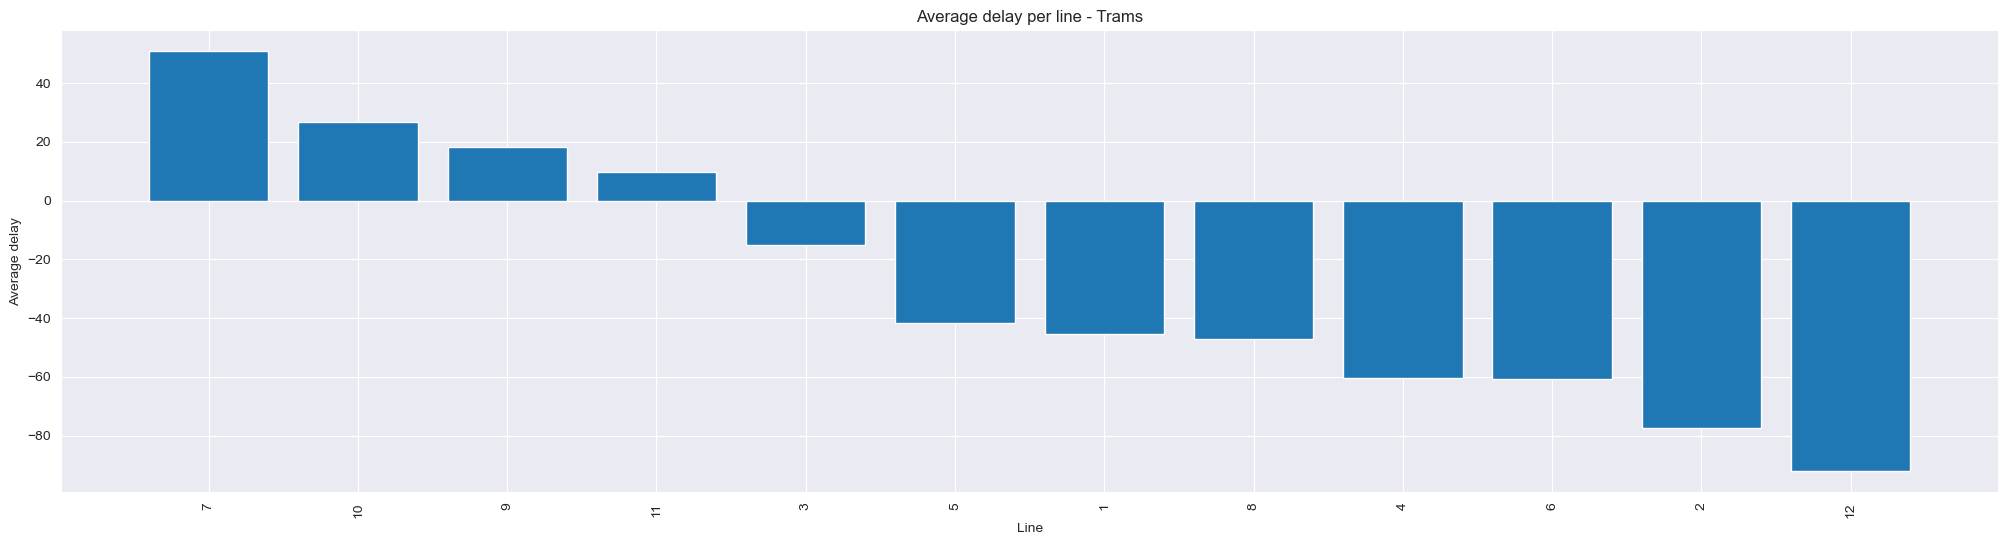

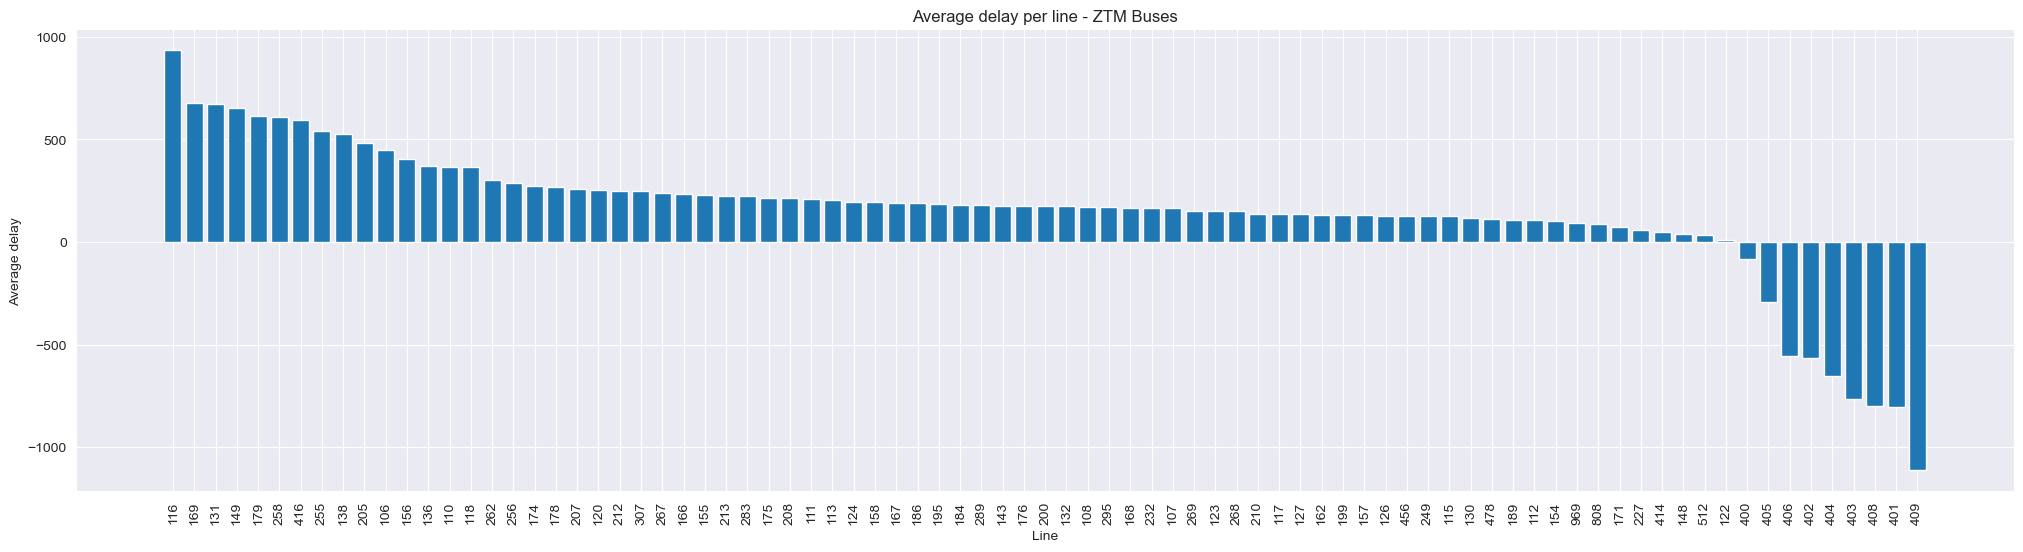

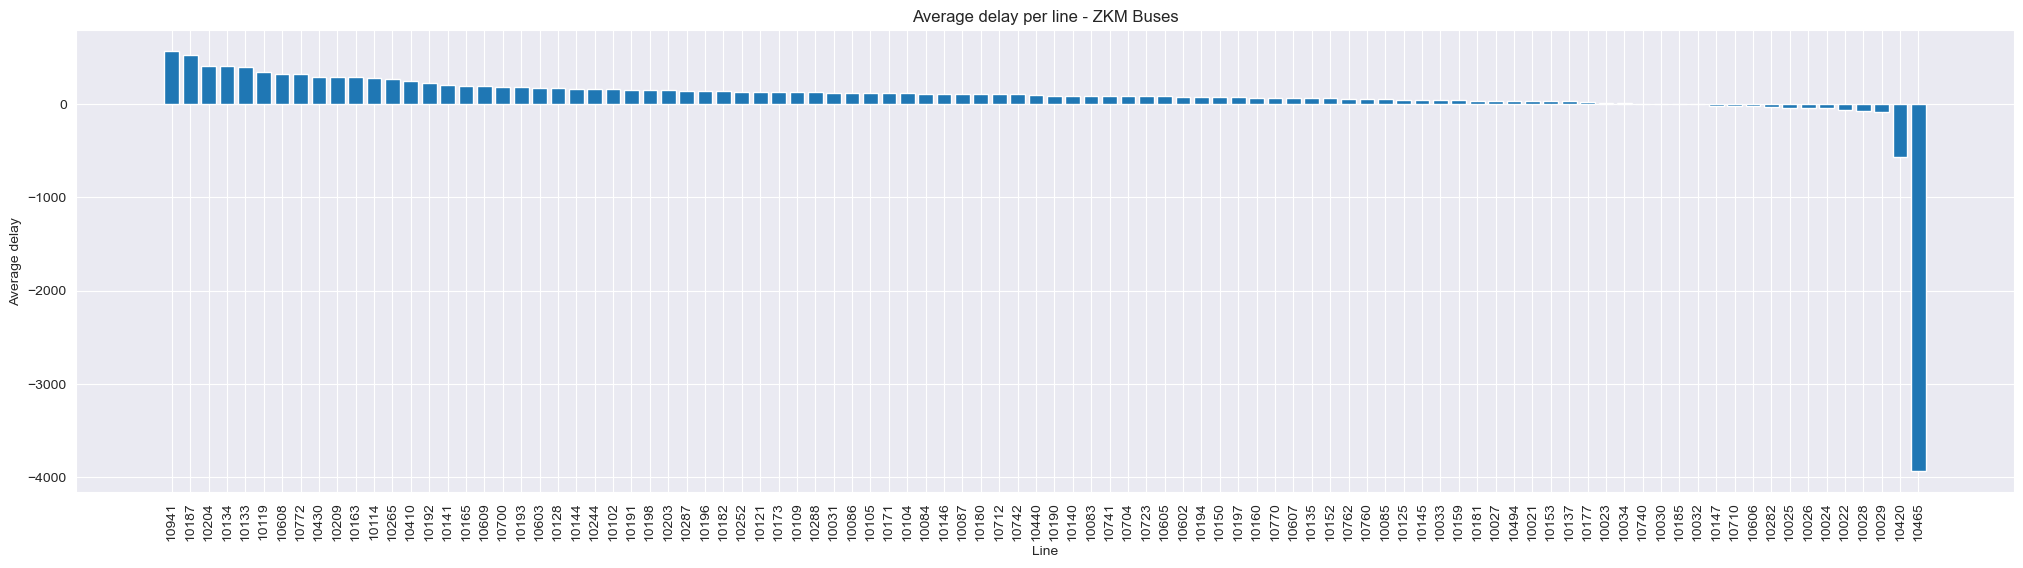

In [38]:
for group, name in zip([trams, ztm_buses, zkm_buses], ['Trams', 'ZTM Buses', 'ZKM Buses']):
    print(f"Group: {name}")
    print(f"Number of unique routes: {len(group.route_id.unique())}")
    print(f"Number of unique trips: {len(group.trip_id.unique())}")
    print(f"Number of unique stops: {len(group.stop_id.unique())}")
    grouped_by_route_id = group.groupby(['route_id']).delay_in_seconds.mean().sort_values(ascending=False)
    plt.figure(figsize=(25,6))
    labels = [str(i) for i in grouped_by_route_id.index]
    plt.bar(labels, grouped_by_route_id.values)
    plt.xticks(labels, rotation=90)
    plt.title(f"Average delay per line - {name}")
    plt.xlabel("Line")
    plt.ylabel("Average delay")

We can see that trams are on average less delayed than buses. ZTM buses are more delayed than ZKM buses. Let's see outliers - the most and least delayed lines.

In [39]:
for group, name in zip([trams, ztm_buses, zkm_buses], ['Trams', 'ZTM Buses', 'ZKM Buses']):
    print(f"Group: {name}")
    grouped_by_route_id = group.groupby(['route_id']).delay_in_seconds.mean().sort_values(ascending=False)
    print(f"Most delayed line: {grouped_by_route_id.idxmax()} - {grouped_by_route_id.max()} s")
    print(f"Least delayed line: {grouped_by_route_id.idxmin()} - {grouped_by_route_id.min()} s")

Group: Trams
Most delayed line: 7 - 50.82681093689258 s
Least delayed line: 12 - -92.13798413195532 s
Group: ZTM Buses
Most delayed line: 116 - 933.5521317011397 s
Least delayed line: 409 - -1113.7626623376623 s
Group: ZKM Buses
Most delayed line: 10941 - 572.7607973421927 s
Least delayed line: 10465 - -3936.8463768115944 s


Are there certain 'delay hotspots in the city'? Let's look at average delay per stop and see which stops, or parts of route accumulate largest delay and if our 'outliers' drive through those spots

In [40]:
grouped_by_stop_id = df_preprocessed.groupby(['stop_desc', 'stop_lat', 'stop_lon']).delay_in_seconds.mean()
grouped_by_stop_id

stop_desc                     stop_lat  stop_lon
1 Maja                        54.58554  18.39318      45.714286
                              54.58567  18.39427      -9.593750
10 Lutego - Skwer Kościuszki  54.51945  18.54174     -17.613208
23 Marca                      54.44807  18.54442      44.487179
                              54.44814  18.54358      69.382979
                                                       ...     
Żwirki i Wigury               54.51553  18.54079     -52.637856
Żwirki i Wigury (N/Ż)         54.39217  18.60602   -3575.817204
Żwirki i Wigury               54.57590  18.38796      47.250000
Życzliwa                      54.34514  18.53617      89.052419
                              54.34588  18.53339     176.805970
Name: delay_in_seconds, Length: 2753, dtype: float64

In [41]:
delay_hotspot_map = folium.Map(map_center,zoom_start=10)
for index, row in grouped_by_stop_id.reset_index().iterrows():
    if row['delay_in_seconds'] < 0:
        color = 'purple'
    elif 0 < row['delay_in_seconds'] < 120:
        color='green'
    elif 120 < row['delay_in_seconds'] < 15*60:
        color='lightred'
    else:
        color="red"
    folium.Marker(
        location=[row['stop_lat'], row['stop_lon']],
        popup=f"{row['stop_desc']}<br> Mean delay: {row['delay_in_seconds']} s",
        icon=folium.Icon(color=color)
    ).add_to(delay_hotspot_map)
    
delay_hotspot_map

In [42]:
districts_gdf = gpd.read_file("D:\\PJATK_MGR\\bus_delay_project\\districts__gdansk.geojson", encoding='utf-8')
print(districts_gdf.crs)
if districts_gdf.crs != "EPSG:4326":
    districts_gdf = districts_gdf.to_crs("EPSG:4326")
districts_gdf

EPSG:4979


id                                    name  \
0   c1NDQ                                 Aniołki   
1   I4NzM                                 Brętowo   
2   kyODI                                 Brzeźno   
3   U2MDk                                   Chełm   
4   YzMjk                                  Jasień   
5   c5MjU                                Kokoszki   
6   AwMzc               Krakowiec-Górki Zachodnie   
7   MwMjg                                 Letnica   
8   M1NTc                                Matarnia   
9   Q1Nzg                                Młyniska   
10  I4NDk                               Nowy Port   
11  E3MzI                                   Oliwa   
12  cwMzI                                Olszynka   
13  I5OTc          Orunia Górna - Gdańsk Południe   
14  I0Mjc               Orunia-Św. Wojciech-Lipce   
15  QwMjc                                   Osowa   
16  kzNjQ                           Piecki-Migowo   
17  IwMTc                               Przeróbka   
18  Y5Mjk                          Przymorze Małe   
19  UyNTQ                       Przymorze Wielkie   
20  AxODg                                 Rudniki   
21  Q5ODU                                 Siedlce   
22  E3NDk                                   Stogi   
23  YwMTM                                 Strzyża   
24  g4OTQ                               Suchanino   
25  A2OTA                             Śródmieście   
26  Q5NDU                     Ujeścisko-Łostowice   
27  E0MjQ                                VII Dwór   
28  QyNjE                          Wrzeszcz Dolny   
29  EwMzQ                          Wrzeszcz Górny   
30  U4Nzc                      Wyspa Sobieszewska   
31  kxMTU                     Wzgórze Mickiewicza   
32  czNjQ                           Zaspa-Młyniec   
33  E4NjU                          Zaspa-Rozstaje   
34  M3NzE  Żabianka-Wejhera-Jelitkowo-Tysiąclecia   

                                          description              styleUrl  \
0   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
1   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0F9D58-1200-92   
2   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-673AB7-1200-92   
3   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-94   
4   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0097A7-1200-92   
5   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0097A7-1200-94   
6   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0F9D58-1200-92   
7   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
8   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0097A7-1200-92   
9   { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-89   
10  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
11  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0F9D58-1200-92   
12  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
13  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0097A7-1200-92   
14  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-94   
15  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0097A7-1200-94   
16  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-673AB7-1200-94   
17  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
18  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-673AB7-1200-94   
19  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-673AB7-1200-94   
20  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
21  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-94   
22  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-0F9D58-1200-92   
23  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-673AB7-1200-94   
24  { "@type": "html", "value": "opis: <br>nazwa_d...  #poly-FBC02D-1200-92   
25  { "@type": "html", "value": "opis: <br>n

In [43]:
districts = [(row.geometry, row['name']) for _, row in districts_gdf.iterrows()]
districts

[(<POLYGON Z ((18.624 54.375 0, 18.624 54.375 0, 18.624 54.375 0, 18.624 54.37...>,
  'Aniołki'),
 (<POLYGON Z ((18.527 54.379 0, 18.527 54.378 0, 18.527 54.377 0, 18.527 54.37...>,
  'Brętowo'),
 (<POLYGON Z ((18.618 54.416 0, 18.618 54.416 0, 18.618 54.416 0, 18.619 54.41...>,
  'Brzeźno'),
 (<POLYGON Z ((18.618 54.345 0, 18.617 54.345 0, 18.617 54.345 0, 18.617 54.34...>,
  'Chełm'),
 (<POLYGON Z ((18.557 54.319 0, 18.557 54.319 0, 18.557 54.319 0, 18.557 54.31...>,
  'Jasień'),
 (<POLYGON Z ((18.431 54.385 0, 18.431 54.385 0, 18.431 54.384 0, 18.431 54.38...>,
  'Kokoszki'),
 (<POLYGON Z ((18.738 54.374 0, 18.738 54.373 0, 18.737 54.373 0, 18.737 54.37...>,
  'Krakowiec-Górki Zachodnie'),
 (<POLYGON Z ((18.629 54.383 0, 18.629 54.383 0, 18.629 54.383 0, 18.63 54.383...>,
  'Letnica'),
 (<POLYGON Z ((18.466 54.406 0, 18.466 54.405 0, 18.466 54.404 0, 18.465 54.40...>,
  'Matarnia'),
 (<POLYGON Z ((18.627 54.381 0, 18.627 54.381 0, 18.627 54.381 0, 18.627 54.38...>,
  'Młyniska'),
 (

In [44]:
grouped_by_stop_id_df = grouped_by_stop_id.reset_index()
grouped_by_stop_id_df

stop_desc  stop_lat  stop_lon  delay_in_seconds
0                           1 Maja  54.58554  18.39318         45.714286
1                           1 Maja  54.58567  18.39427         -9.593750
2     10 Lutego - Skwer Kościuszki  54.51945  18.54174        -17.613208
3                         23 Marca  54.44807  18.54442         44.487179
4                         23 Marca  54.44814  18.54358         69.382979
...                            ...       ...       ...               ...
2748               Żwirki i Wigury  54.51553  18.54079        -52.637856
2749         Żwirki i Wigury (N/Ż)  54.39217  18.60602      -3575.817204
2750              Żwirki i Wigury   54.57590  18.38796         47.250000
2751                      Życzliwa  54.34514  18.53617         89.052419
2752                      Życzliwa  54.34588  18.53339        176.805970

[2753 rows x 4 columns]

In [45]:
# assign district to each stop
def assign_district(stop_lat, stop_lon):
    point = shapely.Point(stop_lon, stop_lat)
    for district in districts:
        if district[0].contains(point):
            return district[1]
    return None

grouped_by_stop_id_df['district'] = grouped_by_stop_id_df.apply(lambda row: assign_district(row['stop_lat'], row['stop_lon']), axis=1)
print(grouped_by_stop_id_df.district.isnull().sum(), grouped_by_stop_id_df.shape)
grouped_by_stop_id_df

1404 (2753, 5)


stop_desc  stop_lat  stop_lon  delay_in_seconds  \
0                           1 Maja  54.58554  18.39318         45.714286   
1                           1 Maja  54.58567  18.39427         -9.593750   
2     10 Lutego - Skwer Kościuszki  54.51945  18.54174        -17.613208   
3                         23 Marca  54.44807  18.54442         44.487179   
4                         23 Marca  54.44814  18.54358         69.382979   
...                            ...       ...       ...               ...   
2748               Żwirki i Wigury  54.51553  18.54079        -52.637856   
2749         Żwirki i Wigury (N/Ż)  54.39217  18.60602      -3575.817204   
2750              Żwirki i Wigury   54.57590  18.38796         47.250000   
2751                      Życzliwa  54.34514  18.53617         89.052419   
2752                      Życzliwa  54.34588  18.53339        176.805970   

            district  
0               None  
1               None  
2               None  
3               None  
4               None  
...              ...  
2748            None  
2749  Zaspa-Rozstaje  
2750            None  
2751          Jasień  
2752          Jasień  

[2753 rows x 5 columns]

In [46]:
grouped_by_district = grouped_by_stop_id_df.groupby('district').delay_in_seconds.mean()
grouped_by_district_df = grouped_by_district.reset_index()
grouped_by_district_df

district  delay_in_seconds
0                                  Aniołki        207.640440
1                                  Brzeźno        151.351803
2                                  Brętowo        679.607621
3                                    Chełm       -331.566321
4                                   Jasień         66.384643
5                                 Kokoszki        103.343703
6                Krakowiec-Górki Zachodnie        275.076850
7                                  Letnica         52.355670
8                                 Matarnia        -13.945043
9                                 Młyniska         67.166105
10                               Nowy Port       -368.460933
11                                   Oliwa        126.480604
12                                Olszynka        461.851260
13          Orunia Górna - Gdańsk Południe       -111.579739
14               Orunia-Św. Wojciech-Lipce         16.900280
15                                   Osowa        204.972174
16                           Piecki-Migowo        -11.348615
17                               Przeróbka        332.231921
18                          Przymorze Małe         54.027740
19                       Przymorze Wielkie        184.247979
20                                 Rudniki       -327.385035
21                                 Siedlce         -1.885700
22                                   Stogi        113.084857
23                                 Strzyża       -860.399177
24                               Suchanino        129.114024
25                     Ujeścisko-Łostowice         81.194959
26                                VII Dwór        164.237465
27                          Wrzeszcz Dolny       -170.552269
28                          Wrzeszcz Górny         52.409572
29                      Wyspa Sobieszewska        104.921948
30                     Wzgórze Mickiewicza        144.567445
31                           Zaspa-Młyniec        156.045466
32                          Zaspa-Rozstaje        -17.092679
33                             Śródmieście        204.594873
34  Żabianka-Wejhera-Jelitkowo-Tysiąclecia        192.020894

In [47]:
import matplotlib.cm as cm
import matplotlib.colors as colors
cmap = cm.get_cmap('coolwarm') 
norm = colors.Normalize(vmin=grouped_by_district_df.delay_in_seconds.min(), 
                        vmax=grouped_by_district_df.delay_in_seconds.max())

m = folium.Map(location=[54.372158, 18.638306], zoom_start=12)

for district in districts:
    delay_per_district = grouped_by_district_df[grouped_by_district_df.district == district[1]].delay_in_seconds.iloc[0]
    
    rgb_color = cmap(norm(delay_per_district))  
    hex_color = colors.to_hex(rgb_color)       

    folium.GeoJson(district[0], 
                   name=district[1], 
                   style_function=lambda feature, color=hex_color: {
                       'fillColor': color,
                       'color': color,
                       'weight': 1,
                       'fillOpacity': 0.7
                   }).add_to(m)

legend_html = f'''
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 250px; height: 120px; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;">
    <b>Delay Legend</b><br>
    <i style="background: {colors.to_hex(cmap(norm(norm.vmin)))}; width: 18px; height: 18px; display: inline-block;"></i> {norm.vmin:.2f} s (Min)<br>
    <i style="background: {colors.to_hex(cmap(0.25))}; width: 18px; height: 18px; display: inline-block;"></i> {norm.vmin + 0.25 * (norm.vmax - norm.vmin):.2f} s<br>
    <i style="background: {colors.to_hex(cmap(0.5))}; width: 18px; height: 18px; display: inline-block;"></i> {norm.vmin + 0.5 * (norm.vmax - norm.vmin):.2f} s<br>
    <i style="background: {colors.to_hex(cmap(0.75))}; width: 18px; height: 18px; display: inline-block;"></i> {norm.vmin + 0.75 * (norm.vmax - norm.vmin):.2f} s<br>
    <i style="background: {colors.to_hex(cmap(norm.vmax))}; width: 18px; height: 18px; display: inline-block;"></i> {norm.vmax:.2f} s (Max)
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))
m

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\1420048671.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


Are there specific days in the dataset that have higher delay than others?

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3235165281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_type['scheduled_trip_start_time'] = pd.to_datetime(group_type['scheduled_trip_start_time'])
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3235165281.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  group_type = group_type[group_type['scheduled_trip_start_time'].dt.date != pd.to_datetime('2024-12-21')]


(667629, 22)
(667625, 22)


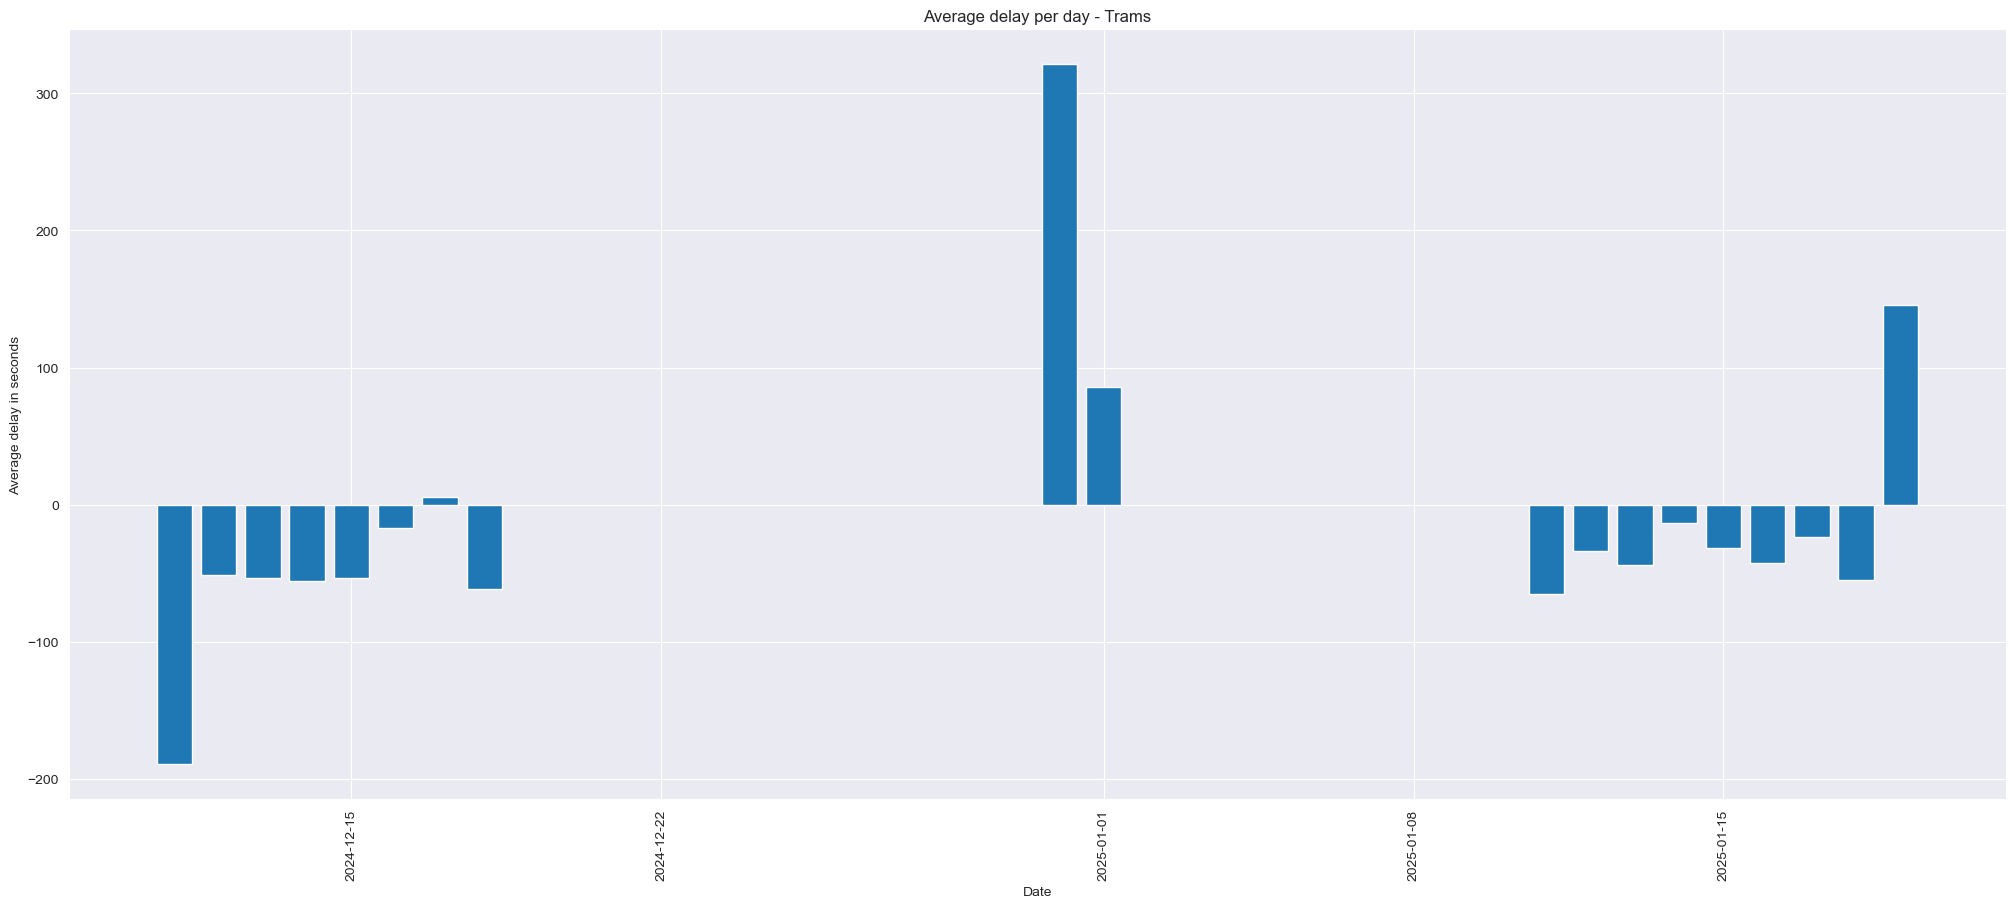

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3235165281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_type['scheduled_trip_start_time'] = pd.to_datetime(group_type['scheduled_trip_start_time'])


(1441183, 22)


C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3235165281.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  group_type = group_type[group_type['scheduled_trip_start_time'].dt.date != pd.to_datetime('2024-12-21')]


(1440877, 22)


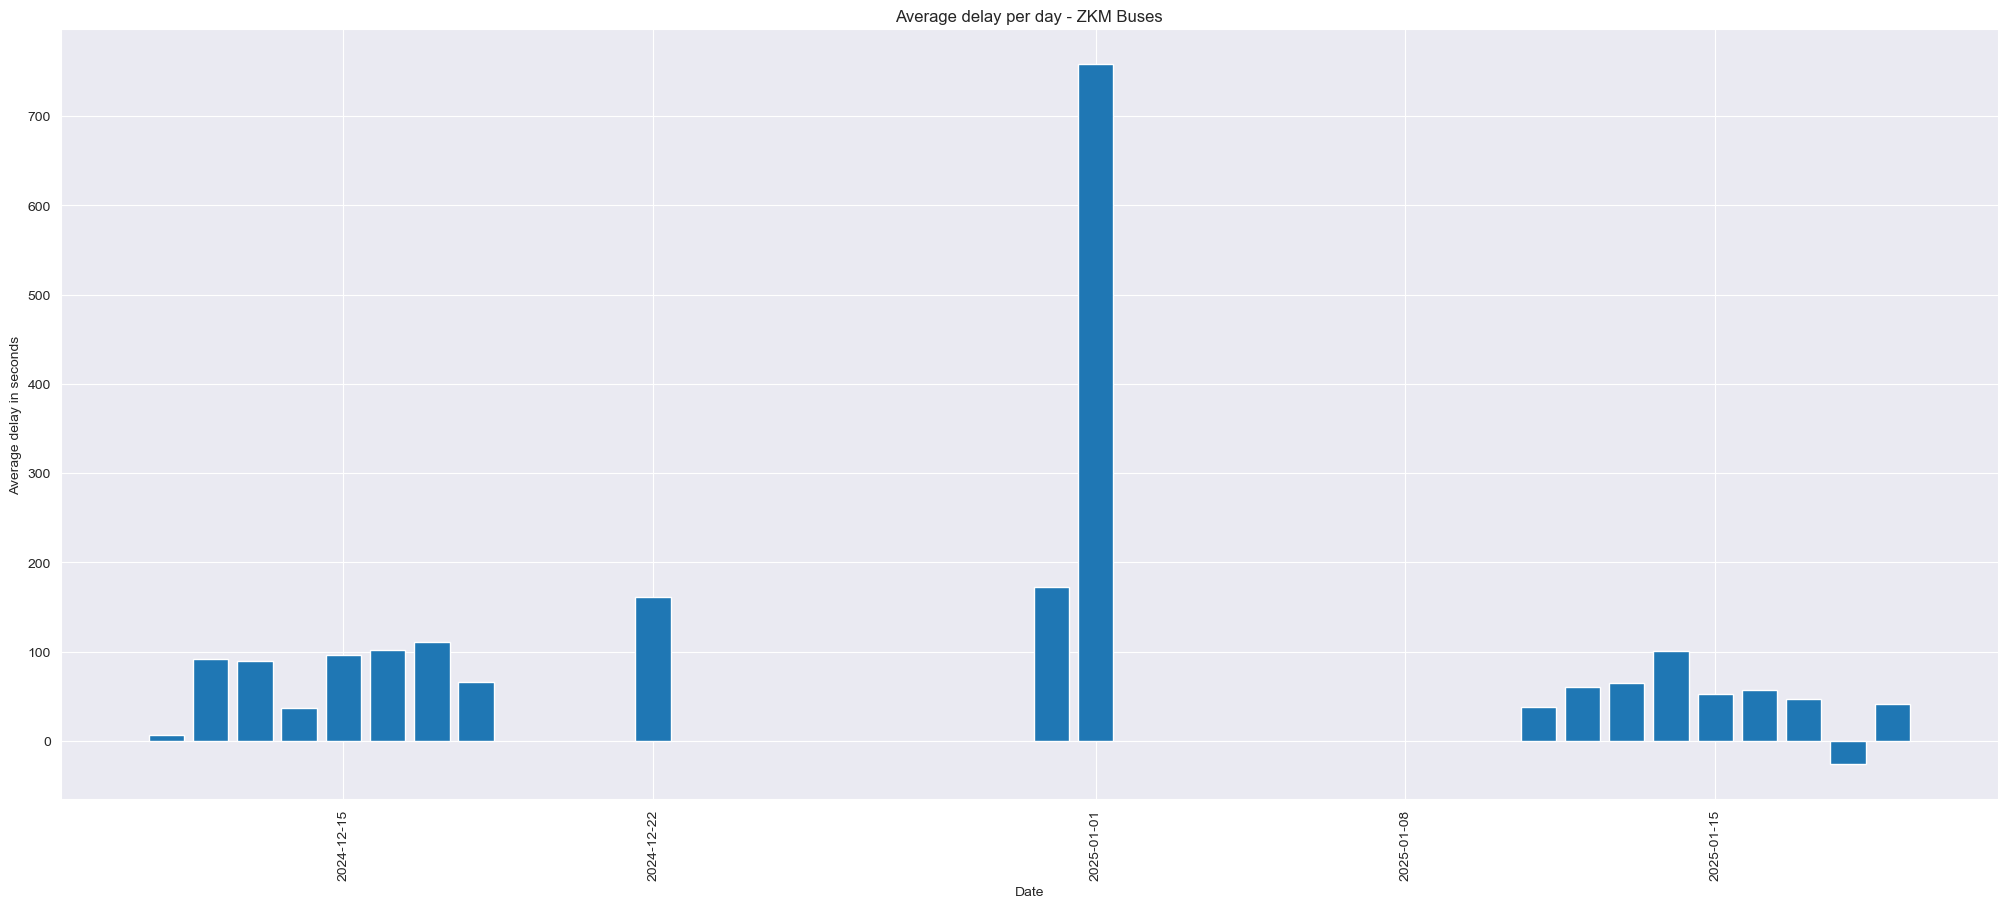

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3235165281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_type['scheduled_trip_start_time'] = pd.to_datetime(group_type['scheduled_trip_start_time'])
C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3235165281.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  group_type = group_type[group_type['scheduled_trip_start_time'].dt.date != pd.to_datetime('2024-12-21')]


(1394075, 22)
(1393553, 22)


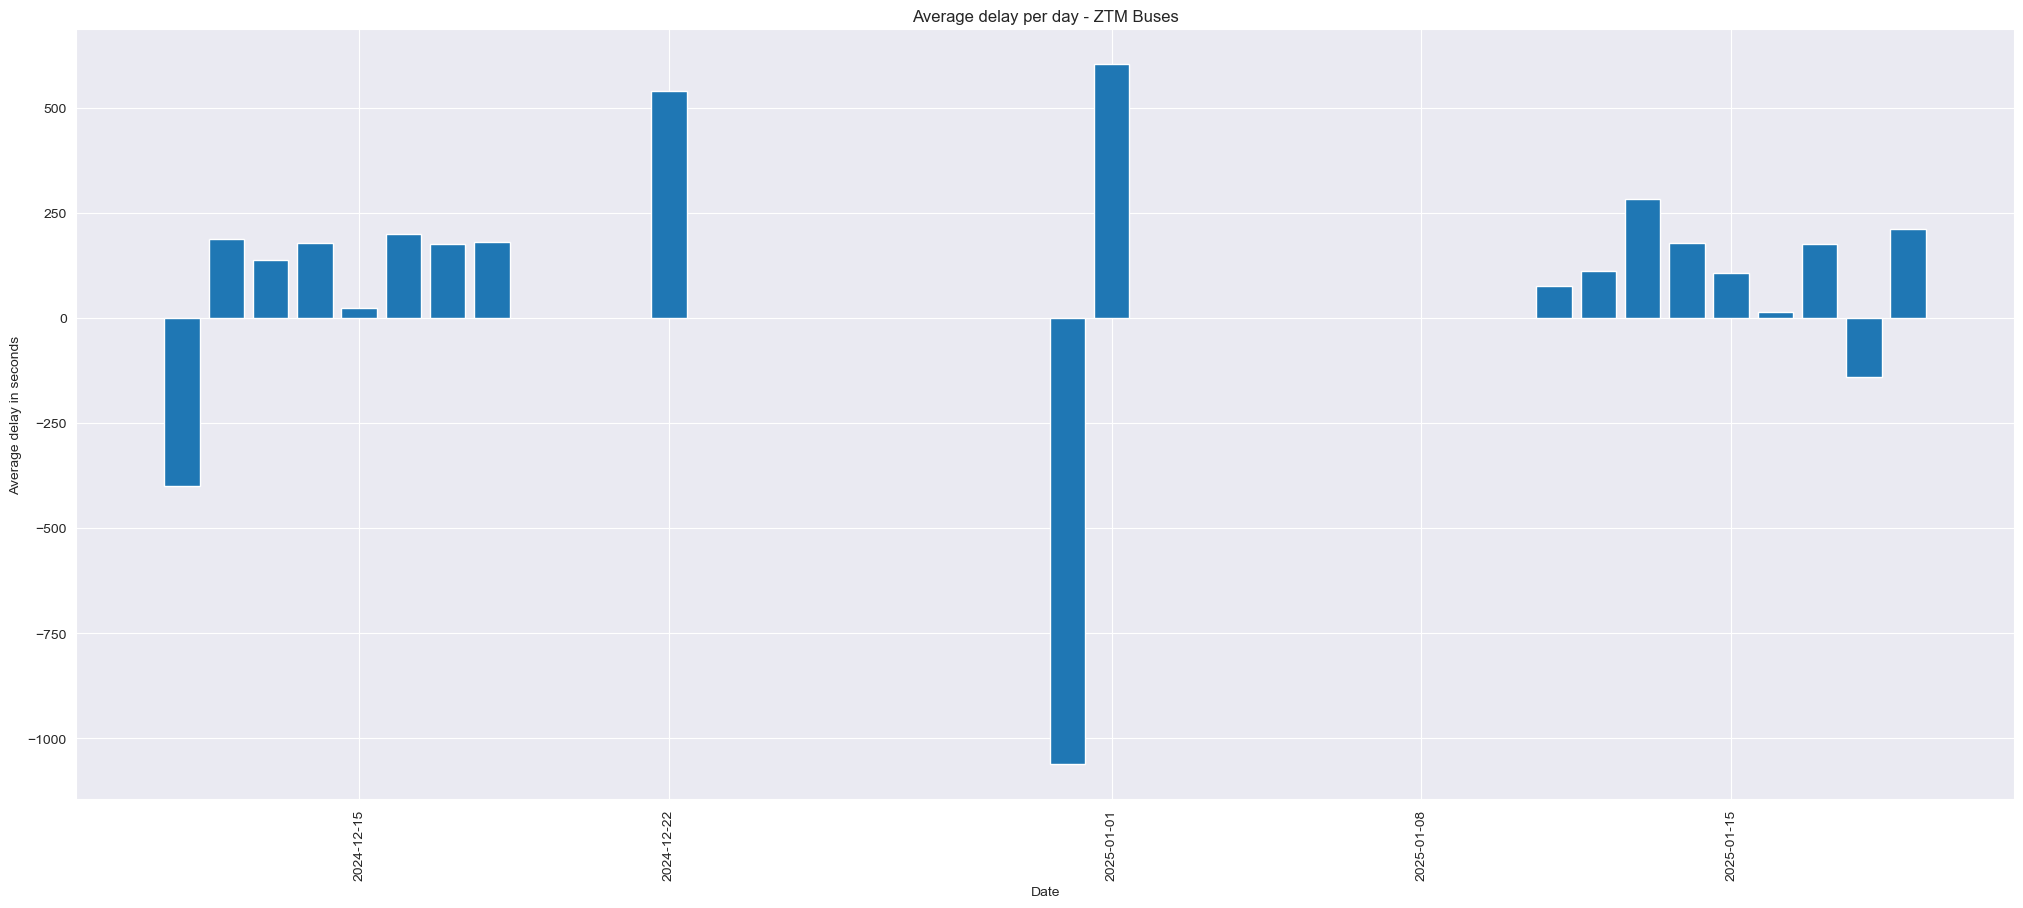

In [48]:
for group_type, name in zip([trams, zkm_buses, ztm_buses], ['Trams', 'ZKM Buses', 'ZTM Buses']):
    group_type['scheduled_trip_start_time'] = pd.to_datetime(group_type['scheduled_trip_start_time'])
    # exclude 2024-12-21 - it seems to be a wrong date
    print(group_type.shape)
    group_type = group_type[group_type['scheduled_trip_start_time'].dt.date != pd.to_datetime('2024-12-21')]
    print(group_type.shape)
    average_delay_per_day = group_type.groupby(group_type['scheduled_trip_start_time'].dt.date).delay_in_seconds.mean()
    plt.figure(figsize=(25, 10))
    plt.bar(average_delay_per_day.index, average_delay_per_day.values, width=0.8)
    plt.title(f'Average delay per day - {name}')
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.ylabel('Average delay in seconds')
    plt.show()


21st of December seems to be wrong - let's check datapoints there

In [49]:
trams_21_dec = trams[trams['scheduled_trip_start_time'].dt.date == pd.to_datetime('2024-12-21').date()]
trams_21_dec

updated_at  stop_id      id  trip_id  route_id  \
27792522 2024-12-22 00:10:45    14804   T21R2       21         2   
27792523 2024-12-22 00:10:45    14804   T31R6       31         6   
27793339 2024-12-22 00:12:25    14804  T122R9      122         9   
27792521 2024-12-22 00:10:45    14804  T21R12       21        12   

         route_short_name     headsign scheduled_trip_start_time  \
27792522                2  Strzyża PKM       2024-12-21 21:24:00   
27792523                6  Strzyża PKM       2024-12-21 22:32:00   
27793339                9  Strzyża PKM       2024-12-21 22:32:00   
27792521               12  Strzyża PKM       2024-12-21 22:41:00   

            theoretical_time      estimated_time  ...           timestamp  \
27792522 2024-12-21 22:33:00 2024-12-22 00:11:01  ... 2024-12-22 00:10:03   
27792523 2024-12-21 23:14:00 2024-12-22 00:11:32  ... 2024-12-22 00:10:02   
27793339 2024-12-21 23:17:00 2024-12-21 00:12:52  ... 2024-12-22 00:10:02   
27792521 2024-12-21 23:31:00 2024-12-22 00:12:38  ... 2024-12-22 00:10:02   

               downloaded_at vehicle_code vehicle_id  vehicle_service  \
27792522 2024-12-22 00:12:05       1079.0   145828.0           002-10   
27792523 2024-12-22 00:12:05       1061.0   145746.0           006-45   
27793339 2024-12-22 00:14:05       1065.0   145755.0           009-43   
27792521 2024-12-22 00:12:05       1023.0      417.0           012-07   

             trip updated_at_to_theoretical_time_difference  \
27792522  4796421                       2024-12-21 22:33:00   
27792523  4806016                       2024-12-21 23:14:00   
27793339  4806086                       2024-12-21 23:17:00   
27792521  4796525                       2024-12-21 23:31:00   

                                stop_desc  stop_lat  stop_lon  
27792522  Zajezdnia Wrzeszcz (techniczny)  54.38993  18.57904  
27792523  Zajezdnia Wrzeszcz (techniczny)  54.38993  18.57904  
27793339  Zajezdnia Wrzeszcz (techniczny)  54.38993  18.57904  
27792521  Zajezdnia Wrzeszcz (techniczny)  54.38993  18.57904  

[4 rows x 22 columns]

### Conslusions and insights gathered from the data analysis
- The data is not complete - there are missing values in the dataset
- The data is not accurate - the delay prediction some time into the future is not very accurate - for now we need to rely on the last value as the ground truth
- The delay is not evenly distributed across the route - there are certain stops that accumulate more delay than others
- The delay is not evenly distributed across the city - there are certain bus lines that are more delayed than others
- Useful attributes for further analysis: stop_lat, stop_lon, route_id, scheduled_trip_start_time, theoretical_time, stop_in_route, delay_in_seconds, Redundant attributed: stop_id, headsign (will be represented in data by the last stop in the route), vehicle_code, vehicle_id, vehicle_service, trip (unique id), timestamp, status (does not provide any useful information for the analysis)
- There is a correlation between mean delay time and holiday - the mean delay time is higher on holidays and on days before holidays

## Data prep for modelling

Let's prepare features fro our model. 

first iteration features:
delay_seconds - target variable

stop_lat
stop_lon - position of the stop

route_id - bus line number
scheduled_trip_start_time - weekday|weekend + morning | .. | evening + holiday | no holiday + number of days before holiday
theoretical_time - weekday|weekend + morning | .. | evening

later:
- stop_in_route - the number of stop in order 1st, 2nd, etc.

- current delays for buses
 

In [50]:
selected_columns = ['route_id', 'scheduled_trip_start_time',
       'theoretical_time', 'delay_in_seconds', 'stop_lat', 'stop_lon', 'trip_id']
df_for_modelling = df_preprocessed[selected_columns]

In [51]:
df_for_modelling.delay_in_seconds.isna().sum() / df_for_modelling.shape[0] * 100

60.46452553895488

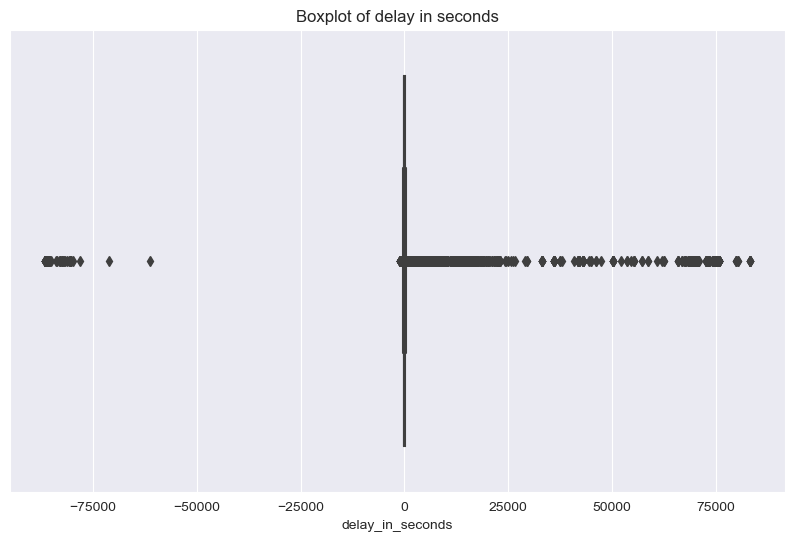

In [52]:
def boxplot_delay():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_for_modelling['delay_in_seconds'])
    plt.title('Boxplot of delay in seconds')
    plt.show()
boxplot_delay()

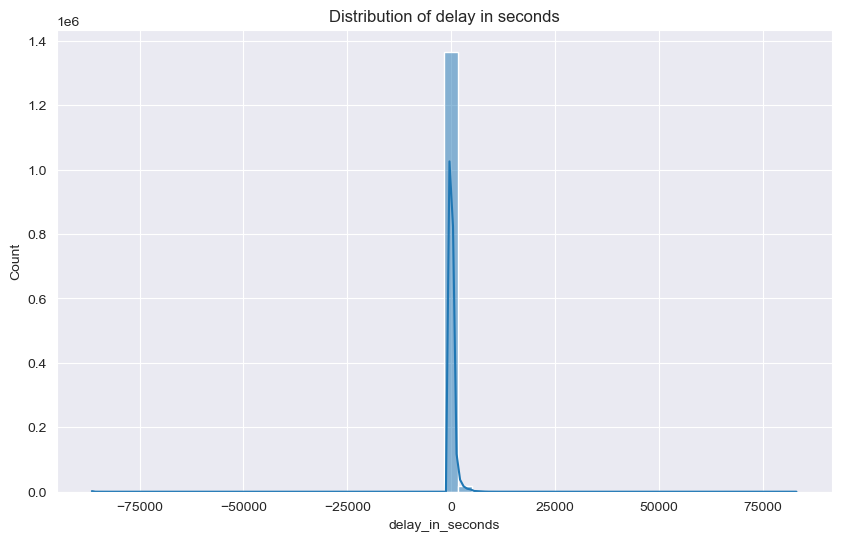

In [53]:
def histplot_delay():
    plt.figure(figsize=(10, 6))
    sns.histplot(df_for_modelling['delay_in_seconds'], bins=50, kde=True)
    plt.title('Distribution of delay in seconds')
    plt.show()
histplot_delay()

In [54]:
# remove outliers i.e. delay > 3h and delay < -3h
print(f"Outliers {df_for_modelling[df_for_modelling['delay_in_seconds'] > 3*60*60].shape[0] / df_for_modelling.shape[0] * 100} %")
print(f"Outliers {df_for_modelling[df_for_modelling['delay_in_seconds'] < -3*60*60].shape[0] / df_for_modelling.shape[0] * 100} %")
df_for_modelling = df_for_modelling[df_for_modelling['delay_in_seconds'] < 3*60*60]
df_for_modelling = df_for_modelling[df_for_modelling['delay_in_seconds'] > - 3*60*60]

Outliers 0.018531073188616104 %
Outliers 0.01693454996005841 %


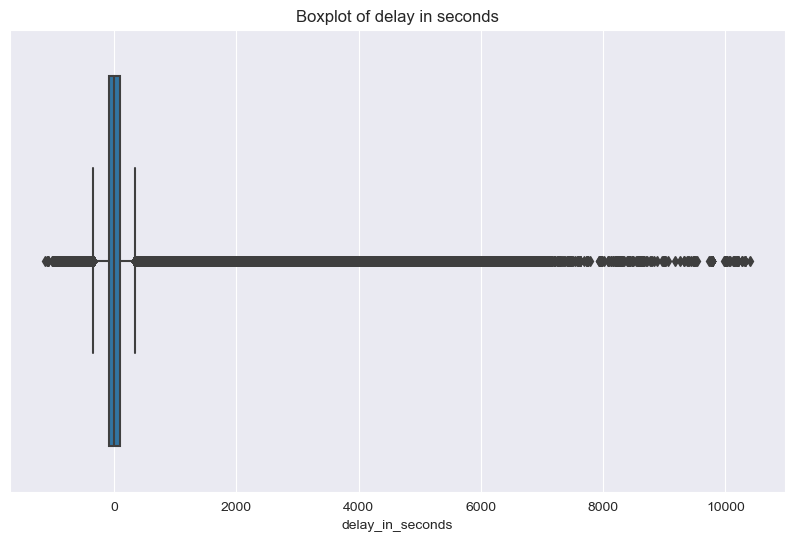

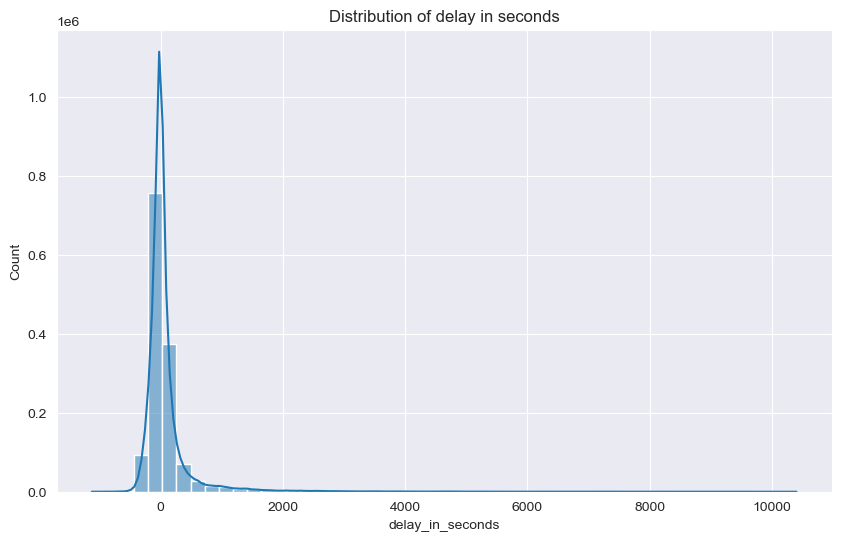

In [55]:
boxplot_delay()
histplot_delay()

In [56]:
df_for_modelling = df_for_modelling.sort_values(by=['route_id', 'scheduled_trip_start_time', 'trip_id', 'theoretical_time'])

df_for_modelling['delay_in_seconds'] = (
    df_for_modelling.groupby(['route_id', 'scheduled_trip_start_time', 'trip_id'])['delay_in_seconds']
      .apply(lambda group: group.interpolate(method='linear')  # Interpolate missing values
                           .fillna(method='bfill')            # Fill remaining with backward fill
                           .fillna(method='ffill'))           # Fill remaining with forward fill
)

C:\Users\48514\AppData\Local\Temp\ipykernel_2712\3967181698.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda group: group.interpolate(method='linear')  # Interpolate missing values


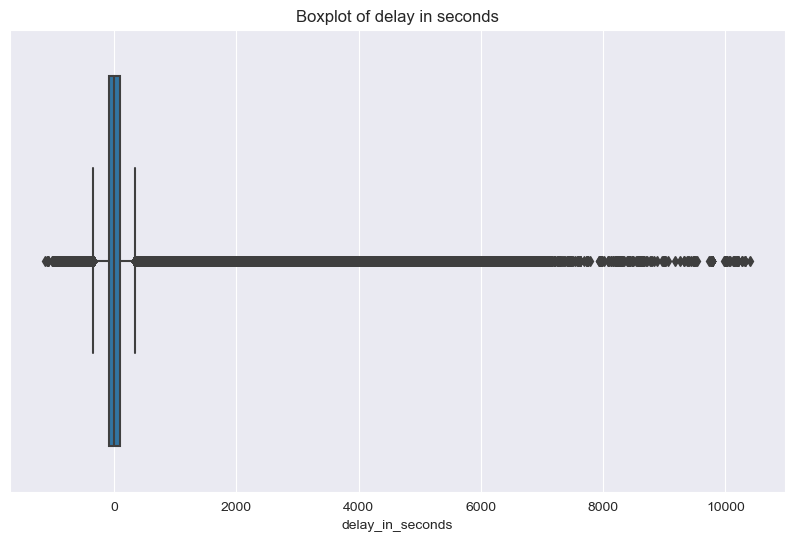

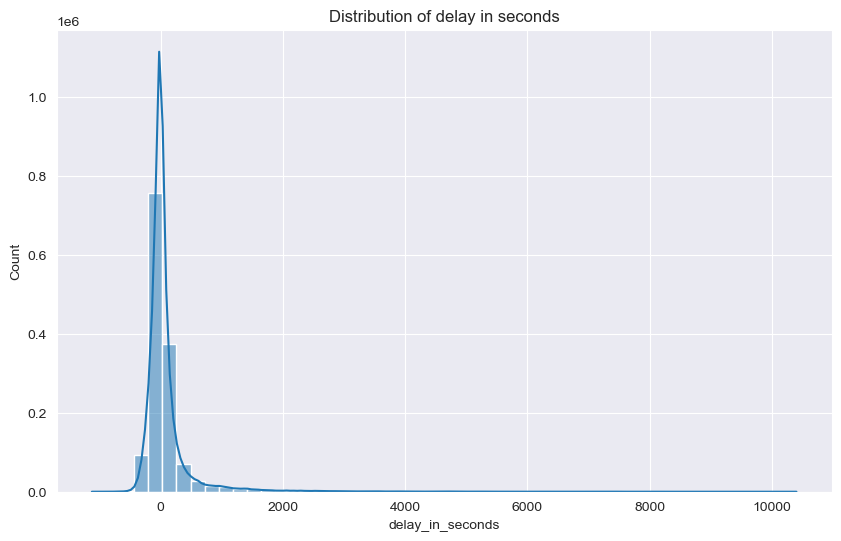

In [57]:
boxplot_delay()
histplot_delay()

In [58]:
df_for_modelling['delay_in_seconds'].isna().sum() / df_for_modelling.shape[0] * 100

7.217553667924687e-05

Let's generate features

In [59]:
def categorize_time_of_day(hour):
    if 23 <= hour or hour <= 4:
        return 'Night'
    elif 5 <= hour <= 7:
        return 'Early Morning'
    elif 8 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 14:
        return 'Afternoon'
    elif 15 <= hour <= 18:
        return 'Evening'
    else:
        return 'Late Evening'
    
def prepare_features_for_modelling(dataframe):
    for col in ['theoretical_time', 'scheduled_trip_start_time']:
        dataframe[col] = pd.to_datetime(dataframe[col])
        dataframe[f'{col}_is_weekday'] = dataframe[col].dt.weekday < 5
        dataframe[f'{col}_time_of_day'] = df[col].dt.hour.apply(categorize_time_of_day)
    return dataframe

df_for_modelling = prepare_features_for_modelling(df_for_modelling)

In [60]:
df_for_modelling.head()

route_id scheduled_trip_start_time    theoretical_time  \
11566960         1       2024-12-14 15:03:00 2024-12-14 15:06:00   
11570032         1       2024-12-14 15:03:00 2024-12-14 15:07:00   
11574955         1       2024-12-14 15:03:00 2024-12-14 15:09:00   
11574945         1       2024-12-14 15:03:00 2024-12-14 15:11:00   
11581575         1       2024-12-14 15:03:00 2024-12-14 15:12:00   

          delay_in_seconds  stop_lat  stop_lon  trip_id  \
11566960             -55.0  54.38843  18.58156       21   
11570032             -15.0  54.38690  18.58521       21   
11574955             -34.0  54.38702  18.59086       21   
11574945            -107.0  54.38214  18.59877       21   
11581575             -39.0  54.37979  18.60319       21   

          theoretical_time_is_weekday theoretical_time_time_of_day  \
11566960                        False                      Evening   
11570032                        False                      Evening   
11574955                        False                      Evening   
11574945                        False                      Evening   
11581575                        False                      Evening   

          scheduled_trip_start_time_is_weekday  \
11566960                                 False   
11570032                                 False   
11574955                                 False   
11574945                                 False   
11581575                                 False   

         scheduled_trip_start_time_time_of_day  
11566960                               Evening  
11570032                               Evening  
11574955                               Evening  
11574945                               Evening  
11581575                               Evening

In [61]:
from workalendar.europe.poland import Poland
Poland().holidays()

def add_holiday_column(dataframe):
    holidays = Poland().holidays(2024)
    dataframe['scheduled_trip_start_time_is_holiday'] = dataframe['scheduled_trip_start_time'].dt.date.isin(holidays)
    dataframe['theoretical_time_is_holiday'] = dataframe['theoretical_time'].dt.date.isin(holidays)
    return dataframe

In [62]:
df_for_modelling = add_holiday_column(df_for_modelling)
df_for_modelling.head()

route_id scheduled_trip_start_time    theoretical_time  \
11566960         1       2024-12-14 15:03:00 2024-12-14 15:06:00   
11570032         1       2024-12-14 15:03:00 2024-12-14 15:07:00   
11574955         1       2024-12-14 15:03:00 2024-12-14 15:09:00   
11574945         1       2024-12-14 15:03:00 2024-12-14 15:11:00   
11581575         1       2024-12-14 15:03:00 2024-12-14 15:12:00   

          delay_in_seconds  stop_lat  stop_lon  trip_id  \
11566960             -55.0  54.38843  18.58156       21   
11570032             -15.0  54.38690  18.58521       21   
11574955             -34.0  54.38702  18.59086       21   
11574945            -107.0  54.38214  18.59877       21   
11581575             -39.0  54.37979  18.60319       21   

          theoretical_time_is_weekday theoretical_time_time_of_day  \
11566960                        False                      Evening   
11570032                        False                      Evening   
11574955                        False                      Evening   
11574945                        False                      Evening   
11581575                        False                      Evening   

          scheduled_trip_start_time_is_weekday  \
11566960                                 False   
11570032                                 False   
11574955                                 False   
11574945                                 False   
11581575                                 False   

         scheduled_trip_start_time_time_of_day  \
11566960                               Evening   
11570032                               Evening   
11574955                               Evening   
11574945                               Evening   
11581575                               Evening   

          scheduled_trip_start_time_is_holiday  theoretical_time_is_holiday  
11566960                                 False                        False  
11570032                                 False                        False  
11574955                                 False                        False  
11574945                                 False                        False  
11581575                                 False                        False

Let's see if there is any pattern between the time of day/holiday/day of the week and the average delay.

In [63]:
df_for_modelling['theoretical_time_time_of_day'].value_counts()

Early Morning    286619
Evening          274948
Afternoon        258060
Late Evening     222858
Morning          218910
Night            124116
Name: theoretical_time_time_of_day, dtype: int64

In [64]:
ztm_buses = df_for_modelling[(df_for_modelling['route_id'] > 100) & (df_for_modelling['route_id'] < 10000)]


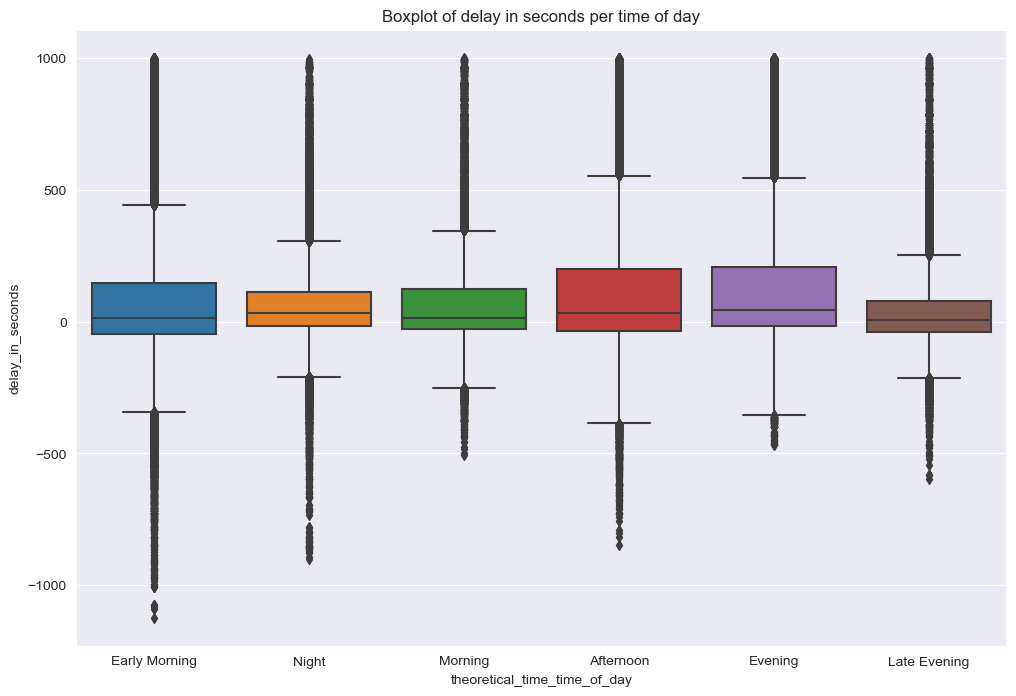

In [65]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='theoretical_time_time_of_day', y='delay_in_seconds', data=ztm_buses[ztm_buses['delay_in_seconds'] < 1000])
plt.title('Boxplot of delay in seconds per time of day')
plt.show()

Text(0.5, 1.0, 'Boxplot of delay in seconds per day of the week')

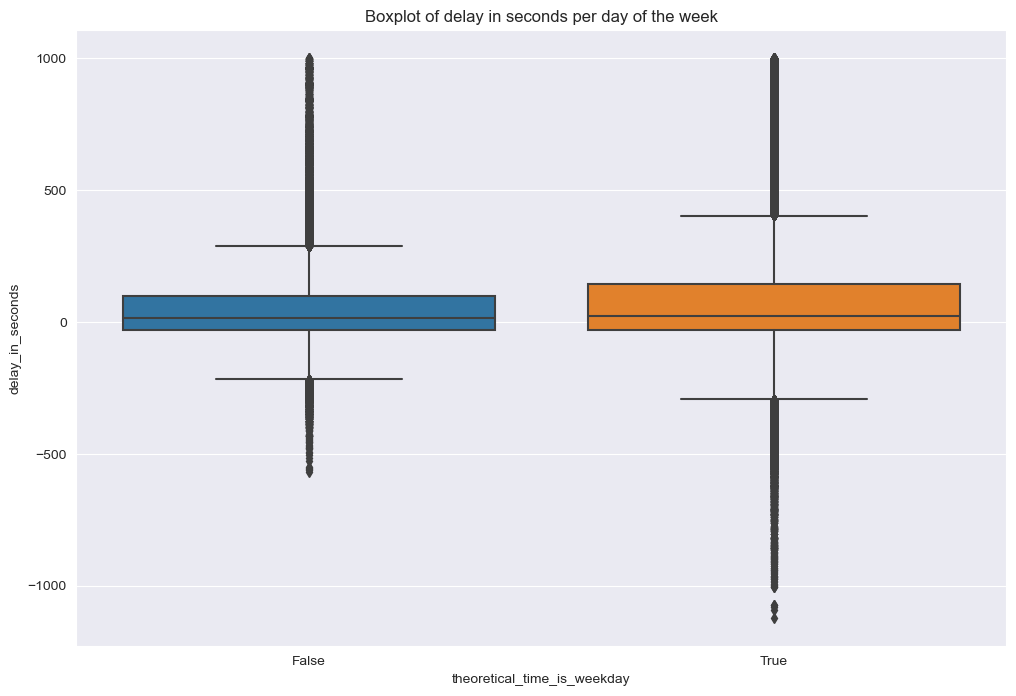

In [66]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='theoretical_time_is_weekday', y='delay_in_seconds', data=ztm_buses[ztm_buses['delay_in_seconds'] < 1000])
plt.title('Boxplot of delay in seconds per day of the week')

Model training - let's start with a simple linear regression model

In [69]:
df_for_modelling.isna().sum() / df_for_modelling.shape[0] * 100

route_id                                 0.0
scheduled_trip_start_time                0.0
theoretical_time                         0.0
delay_in_seconds                         0.0
stop_lat                                 0.0
stop_lon                                 0.0
trip_id                                  0.0
theoretical_time_is_weekday              0.0
theoretical_time_time_of_day             0.0
scheduled_trip_start_time_is_weekday     0.0
scheduled_trip_start_time_time_of_day    0.0
scheduled_trip_start_time_is_holiday     0.0
theoretical_time_is_holiday              0.0
dtype: float64

In [67]:
df_for_modelling = df_for_modelling.dropna()

In [68]:
df_for_modelling.to_csv("D:\\PJATK_MGR\\bus_delay_project\\df_for_modelling_2.csv", index=True)

In [3]:
df_for_modelling = pd.read_csv("D:\\PJATK_MGR\\bus_delay_project\\df_for_modelling_2.csv")

In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


X = df_for_modelling[['route_id', 'stop_lat', 'stop_lon', 'scheduled_trip_start_time_is_weekday', 
                      'scheduled_trip_start_time_time_of_day', 'theoretical_time_is_weekday', 
                      'theoretical_time_time_of_day', 'scheduled_trip_start_time_is_holiday', 
                      'theoretical_time_is_holiday']]
y = df_for_modelling['delay_in_seconds']

X = pd.get_dummies(X, columns=['scheduled_trip_start_time_time_of_day', 'theoretical_time_time_of_day'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

linear_regression_model = LinearRegression()
decision_tree_regressor = DecisionTreeRegressor(random_state=0)
random_forest_regressor = RandomForestRegressor(random_state=0)
gradient_boosting_regressor = GradientBoostingRegressor(random_state=0)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5) 



In [71]:
for model in [linear_regression_model, decision_tree_regressor, random_forest_regressor, gradient_boosting_regressor]:
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=rmse_scorer)
    print(f"Model: {model.__class__.__name__}")
    print(f"Cross-Validated RMSE Scores: {cv_scores}")
    print(f"Mean RMSE: {np.mean(cv_scores)}, Standard Deviation: {np.std(cv_scores)}")

Model: LinearRegression
Cross-Validated RMSE Scores: [ -523.6801507   -679.24110669 -7039.97497327  -215.11222795
  -501.57038601]
Mean RMSE: -1791.9157689236254, Standard Deviation: 2628.303350590411
Model: DecisionTreeRegressor
Cross-Validated RMSE Scores: [-547.40999256 -962.99542734 -606.9869754  -523.94241472 -632.46975737]
Mean RMSE: -654.7609134788372, Standard Deviation: 159.01286751232584
Model: RandomForestRegressor
Cross-Validated RMSE Scores: [-540.51254656 -789.99870431 -584.98347404 -411.72175242 -567.49147447]
Mean RMSE: -578.9415903586741, Standard Deviation: 121.7801137067477
Model: GradientBoostingRegressor
Cross-Validated RMSE Scores: [-527.58622054 -684.51103099 -542.93997356 -204.22028575 -529.07982453]
Mean RMSE: -497.66746707367383, Standard Deviation: 158.08430248112276


Let's now see predictions of the best model - let's look at examples where model performs well and where it performs poorly.

In [5]:
best_model = random_forest_regressor
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)

In [6]:
pd.DataFrame({'True': y_train, 'Predicted': y_pred}).head(20)

True  Predicted
0   -55.0 -72.450245
1   -15.0 -41.293171
2   -34.0 -68.108270
3  -107.0 -93.422845
4   -39.0 -49.737254
5   -85.0 -91.841272
6   -55.0 -69.931278
7   -15.0 -62.062012
8   -27.0 -92.401599
9   -26.0 -74.709676
10   -6.0 -78.820841
11  -10.0 -74.833923
12  -26.0 -88.755576
13    7.0 -20.420524
14   -7.0 -48.069167
15  -84.0 -94.692491
16  -19.0 -99.339411
17   44.0 -57.409781
18   34.0 -60.668303
19   -9.0 -83.050798

In [ ]:
import shap
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})

explainer = shap.Explainer(random_forest_regressor, X_train)

shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

# shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


Global Feature Importance:

The shap.summary_plot() shows the most important features driving the model's predictions across all test samples.
Positive SHAP values push predictions up; negative values push them down.
Force Plot for Individual Predictions:

The shap.force_plot() shows how each feature contributes to a single prediction.


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1107212 entries, 0 to 1107211
Data columns (total 19 columns):
 #   Column                                               Non-Null Count    Dtype  
---  ------                                               --------------    -----  
 0   route_id                                             1107212 non-null  int64  
 1   stop_lat                                             1107212 non-null  float64
 2   stop_lon                                             1107212 non-null  float64
 3   scheduled_trip_start_time_is_weekday                 1107212 non-null  bool   
 4   theoretical_time_is_weekday                          1107212 non-null  bool   
 5   scheduled_trip_start_time_is_holiday                 1107212 non-null  bool   
 6   theoretical_time_is_holiday                          1107212 non-null  bool   
 7   scheduled_trip_start_time_time_of_day_Afternoon      1107212 non-null  uint8  
 8   scheduled_trip_start_time_time_of_day_Earl

In [ ]:
shap.dependence_plot("stop_lat", shap_values, X_train)


Let's remove stop (covered by lat lon) and add vehicle id and see if the model improves

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    }
    
    # Create model
    model = GradientBoostingRegressor(**params, random_state=42)
    
    # Cross-validation score
    score = -np.mean(cross_val_score(model, X_val, y_val, cv=5, scoring="neg_mean_squared_error"))
    
    return score

# Run Optuna optimization
study = optuna.create_study(direction="minimize")  # Minimize MSE
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters:", study.best_params)

# Train model with best parameters
best_model = GradientBoostingRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

# Test set performance
y_pred = best_model.predict(x_test)
test_mse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {test_mse}")


[I 2025-01-21 20:11:20,022] A new study created in memory with name: no-name-7627da3c-ebd4-4998-a79a-39fe3922700d
[I 2025-01-21 20:13:24,405] Trial 0 finished with value: 189296.26948388823 and parameters: {'n_estimators': 413, 'learning_rate': 0.028722246978937323, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 14, 'subsample': 0.7892430750887236}. Best is trial 0 with value: 189296.26948388823.
[I 2025-01-21 20:17:23,255] Trial 1 finished with value: 171250.17918234033 and parameters: {'n_estimators': 404, 'learning_rate': 0.012524622910451338, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 11, 'subsample': 0.6462777779225127}. Best is trial 1 with value: 171250.17918234033.
[I 2025-01-21 20:19:49,003] Trial 2 finished with value: 155622.05118998798 and parameters: {'n_estimators': 186, 'learning_rate': 0.16218473072456718, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.7770366758139514}. Best is trial 2 with value: 155622.0

For long there has been a heated debate - who has it worse - the users of 210 or 126 bus. I have a strong opinion - but I'll let the data speak.